In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
import datetime
import time

import re
import pickle
import datetime
from pathlib import Path

from time import strftime, localtime

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.feature_selection import SelectFromModel, RFECV
from tqdm.notebook import tqdm

from xgboost import XGBClassifier

import math

import keras
import tensorflow as tf

from scipy.stats import norm
from IPython.display import clear_output, display
from tensorflow.python.framework.ops import disable_eager_execution

from clickhouse_driver import Client
from clickhouse_driver.errors import ServerException

from timeit import default_timer as timer

import mlxtend
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from catboost import CatBoostClassifier

import jsonpickle
import json

2023-05-09 10:47:17.308453: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Анализ и предобработка данных

In [2]:
# Добавим новые столбцы, каждый из которых соответствует одному из флагов TCP
def convert_tcp_flags_column(data):
    data['fin'] = data['flags'].str[-1]
    data['syn'] = data['flags'].str[-2]
    data['reset'] = data['flags'].str[-3]
    data['push'] = data['flags'].str[-4]
    data['ack'] = data['flags'].str[-5]
    data['urgent'] = data['flags'].str[-6]
    data['ece'] = data['flags'].str[-7]
    data['cwr'] = data['flags'].str[-8]


    # Далее, произведём перевод к числовым типам новые столбцы для более быстрой обработки
    fin_unique = ['.', 'F']
    data['fin'].replace(fin_unique, list(range(0, len(fin_unique))), inplace = True)
    data['fin'] = data['fin'].astype('int8')

    syn_unique = ['.', 'S']
    data['syn'].replace(syn_unique, list(range(0, len(syn_unique))), inplace = True)
    data['syn'] = data['syn'].astype('int8')

    reset_unique = ['.', 'R']
    data['reset'].replace(reset_unique, list(range(0, len(reset_unique))), inplace = True)
    data['reset'] = data['reset'].astype('int8')

    push_unique = ['.', 'P']
    data['push'].replace(push_unique, list(range(0, len(push_unique))), inplace = True)
    data['push'] = data['push'].astype('int8')

    ack_unique = ['.', 'A']
    data['ack'].replace(ack_unique, list(range(0, len(ack_unique))), inplace = True)
    data['ack'] = data['ack'].astype('int8')

    urgent_unique = ['.','U']
    data['urgent'].replace(urgent_unique, list(range(0, len(urgent_unique))), inplace = True)
    data['urgent'] = data['urgent'].astype('int8')

    ece_unique = ['.', 'E']
    data['ece'].replace(ece_unique, list(range(0, len(ece_unique))), inplace = True)
    data['ece'] = data['ece'].astype('int8')

    cwr_unique = ['.', 'C']
    data['cwr'].replace(cwr_unique, list(range(0, len(cwr_unique))), inplace = True)
    data['cwr'] = data['cwr'].astype('int8')


    data = data.drop('flags', axis = 1) # Убираем старую колонку

    return data


def convert_to_appropriate_dtype(data, source_csv = False, new_dataset = False):
    if new_dataset:
        data['sip'] = data['sip'].astype('str')
        data['tsstart'] = data['tsstart'].astype('uint32')
        data['tsend'] = data['tsend'].astype('uint32')
        data['con_cnt'] = data['con_cnt'].astype('uint32')
        
        data['prot_cnt'] = data['prot_cnt'].astype('uint32')
        data['tcp_cnt'] = data['tcp_cnt'].astype('uint32')
        data['udp_cnt'] = data['udp_cnt'].astype('uint32')
        data['sport_cnt'] = data['sport_cnt'].astype('uint32')
        data['dport_cnt'] = data['dport_cnt'].astype('uint32')
        data['pkts_sum'] = data['pkts_sum'].astype('uint32')
        data['bytes_sum'] = data['bytes_sum'].astype('uint64')
        data['avrg_bps'] = data['avrg_bps'].astype('float32')
        data['avrg_pps'] = data['avrg_pps'].astype('float32')
        data['avrg_bpp'] = data['avrg_bpp'].astype('float32')
        
        data['fin_cnt'] = data['fin_cnt'].astype('uint32')
        data['syn_cnt'] = data['syn_cnt'].astype('uint32')
        data['reset_cnt'] = data['reset_cnt'].astype('uint32')
        data['push_cnt'] = data['push_cnt'].astype('uint32')
        data['ack_cnt'] = data['ack_cnt'].astype('uint32')
        data['urgent_cnt'] = data['urgent_cnt'].astype('uint32')
        data['ece_cnt'] = data['ece_cnt'].astype('uint32')
        data['cwr_cnt'] = data['cwr_cnt'].astype('uint32')
        
    else:
        data['tsstart'] = data['tsstart'].astype('uint32')
        data['tsend'] = data['tsend'].astype('uint32')

        data['duration'] = data['duration'].astype('float32')

        data['prot'] = data['prot'].astype('uint8')

        data['sport'] = data['sport'].astype('uint16')
        data['dport'] = data['dport'].astype('uint16')

        data['pkts'] = data['pkts'].astype('uint32')
        data['bytes'] = data['bytes'].astype('uint64')
        data['flows'] = data['flows'].astype('uint32')
        data['bps'] = data['bps'].astype('uint64')
        data['pps'] = data['pps'].astype('uint32')
        data['bpp'] = data['bpp'].astype('uint64')

        if source_csv == False:
            data['sip'] = data['sip'].astype('uint16')
            data['fin'] = data['fin'].astype('uint8')
            data['syn'] = data['syn'].astype('uint8')
            data['reset'] = data['reset'].astype('uint8')
            data['push'] = data['push'].astype('uint8')
            data['ack'] = data['ack'].astype('uint8')
            data['urgent'] = data['urgent'].astype('uint8')
            data['ece'] = data['ece'].astype('uint8')
            data['cwr'] = data['cwr'].astype('uint8')
    
    return data

In [3]:
# Загрузим данные и посмотрим на небольшую часть
data = pd.read_csv('/data/jupyter/data/proc_csv/onedirectional_csv/csv_ip/10.5.1.179.csv', skipinitialspace = True)
data.head()

,tsstart,tsend,duration,prot,sip,sport,dport,pkts,bytes,flows,...,bpp,dir,fin,syn,reset,push,ack,urgent,ece,cwr
0,1604395220,1604395220,0.0,6,415,59028,443,1,40,1,...,40,I,0,1,0,0,0,0,0,0
1,1605528362,1605528362,0.0,6,415,40706,80,1,40,1,...,40,I,0,1,0,0,0,0,0,0
2,1605627175,1605627175,0.0,6,415,40866,80,1,40,1,...,40,I,0,1,0,0,0,0,0,0
3,1612200629,1612200629,0.0,17,415,123,123,1,48,1,...,48,I,0,0,0,0,0,0,0,0
4,1612200630,1612200630,0.0,17,415,123,123,1,48,1,...,48,I,0,0,0,0,0,0,0,0


In [5]:
# Посмотрим, за какой промежуток данные и сколько всего записей
print('Самая ранняя запись:', data['tsstart'].min())
print('Самая поздняя запись:', data['tsstart'].max())
print('Всего записей:', data.shape[0])

Самая ранняя запись: 1604395220
Самая поздняя запись: 1664792260
Всего записей: 2025


In [ ]:
pd.set_option("display.max_rows", None)
data['sip'].value_counts()

In [ ]:
#Удалю лидирующие пробелы из колонки sip
data['sip'] = data['sip'].str.strip()
data['dip'] = data['dip'].str.strip()

In [ ]:
# Убираю нелокальные хосты
data.drop( data[~ (data['sip'].str.startswith("192.168") | data['sip'].str.startswith("10."))].index , inplace = True)
data.head()

In [ ]:
# Посмотрим, за какой промежуток остались данные и сколько всего стало записей
print('Самая ранняя запись: ', data['tstart'].min())
print('Самая поздняя запись: ', data['tstart'].max())
print('Всего записей: ', data.shape[0])

In [ ]:
data = convert_tcp_flags_column(data)
data.head()

In [ ]:
# Уберём ненужные столбцы - строковые представления времени начала и конца потока
data = data.drop('tstart', axis = 1)
data = data.drop('tend', axis = 1)

In [ ]:
# Уберу дубликаты
data.drop_duplicates(inplace = True)

In [ ]:
for col in data.columns:
    print("Count of Nan rows in " + col + " is: ", data[col].isna().sum())

# Уберём Nan
data = data.dropna()

data.head()


In [6]:
# Посмотрим на распределение фичей
pd.set_option("display.max_rows", 60)

for col in data.columns:
    print(f"{col} DISTRIBUTION")
    print(data[col].value_counts())
    print()

tsstart DISTRIBUTION
1657936790    8
1658965686    5
1658965687    5
1615358156    5
1615358161    4
             ..
1630842964    1
1630841760    1
1630840862    1
1630840260    1
1664792260    1
Name: tsstart, Length: 1989, dtype: int64

tsend DISTRIBUTION
1658965687    5
1657936791    5
1615358156    5
1615358161    4
1657936790    4
             ..
1630937154    1
1630932661    1
1630932058    1
1630842964    1
1664792260    1
Name: tsend, Length: 1992, dtype: int64

duration DISTRIBUTION
0.000      1472
0.207         5
0.205         5
20.227        4
20.229        4
           ... 
40.606        1
50.255        1
121.317       1
50.459        1
0.031         1
Name: duration, Length: 486, dtype: int64

prot DISTRIBUTION
6     1835
17     183
1        7
Name: prot, dtype: int64

sip DISTRIBUTION
415    2025
Name: sip, dtype: int64

sport DISTRIBUTION
60452    355
50055     93
49628     32
123       31
3001      21
        ... 
51970      1
48090      1
47630      1
47176      1
370

In [ ]:
# Как мы видим, в некоторых колонках только одно значение, их можно убрать
data = data.drop(columns = ['dir', 'flows'])

In [ ]:
sip_unique = data['sip'].unique()
sip_unique_code = dict([(ip, cls + 1) for cls, ip in enumerate(sip_unique)])
data['sip'] = data['sip'].apply((lambda val : sip_unique_code[val]))

In [ ]:
# Уточним тип данных всех числовых типов
data = convert_to_appropriate_dtype(data)

## Построение графиков параллельных координат

In [ ]:
# Графики параллельных координат
# 1. Графики с фиксированным SIP

time_seg = 2 # Число сегментов в одном часе

def port_process(port):
    if port <= 1024:
        return 1/3 * (port / 1024)
    else:
        return 1/3 + (2/3 * (port / 65535))
    
def parallel_coordinated_fixed_sip(ip, prot, data, this_datetime, graphics_path):
    this_timestamp = this_datetime.timestamp()
    date = this_datetime.strftime('%Y-%m-%d')
    
    cur_ip_data = data[(data['sip'] == ip) & (data['prot'] == prot[1])]

    flowsPerService = cur_ip_data[['sport', 'dport']].value_counts(ascending = True).reset_index(name = 'flowsPerService')

    dIPsPerService = cur_ip_data.groupby(['sport', 'dport'])['dip'].nunique().reset_index(name = 'dIPsPerService')

    merged_test = cur_ip_data.merge(flowsPerService, how = 'inner', on = ['sport', 'dport'])

    merged_test = merged_test.merge(dIPsPerService, how = 'inner', on = ['sport', 'dport'])

    merged_test = merged_test[['tsstart', 'sport', 'dport', 'flowsPerService', 'dIPsPerService']]

    merged_test['tsstart'] = merged_test['tsstart'].apply(lambda x: (x - this_timestamp) / (60 * 60))

    merged_test = merged_test[merged_test['tsstart'] >= 0]

    merged_test['sport'] = merged_test['sport'].apply(port_process)
    merged_test['dport'] = merged_test['dport'].apply(port_process)

    merged_test['tsstart'] = merged_test['tsstart'].apply(lambda x: int(x * time_seg))

    merged_test.drop_duplicates(inplace = True)
    
    if merged_test.shape[0] == 0:
        return 0
    
    print("Всего записей за день " + date + " для IP " + ip + " (" + prot[0] + "):", merged_test.shape[0])

    fig = go.Figure(data =
    go.Parcoords(
        line_color = 'blue',
        dimensions = list([
            dict(range = [0, 24 * time_seg],
                    tickvals = [int(i * time_seg) for i in range(0, 25, 2)],
                    ticktext = [str(i) for i in range(0, 25, 2)],
                    label = 'Time', values = merged_test['tsstart']),
            dict(range = [0, 1],
                    tickvals = [port_process(i) for i in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1024, 10000, 20000, 30000, 40000, 50000, 65535]],
                    ticktext = [str(i) for i in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1024, 10000, 20000, 30000, 40000, 50000, 65535]],
                    label = 'SPort', values = merged_test['sport']),
            dict(range = [0, 1],
                    tickvals = [port_process(i) for i in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1024, 10000, 20000, 30000, 40000, 50000, 65535]],
                    ticktext = [str(i) for i in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1024, 10000, 20000, 30000, 40000, 50000, 65535]],
                    label = 'DPort', values = merged_test['dport']),
            dict(
                    label = 'FlowsPerService', values = merged_test['flowsPerService']),
            dict(
                    label = 'DIPsPerService', values = merged_test['dIPsPerService'])
        ]),
    ),
    layout  = { 'title' : 'SIP ' + ip + ' ' + prot[0] + ' (' + date + ')'}
    )

    fig.write_image(graphics_path + ip + '/SIP ' + ip + ' ' + prot[0] + ' (' + date + ').jpg', format = 'jpg', width = 1920, height = 1080)
    return 1

In [ ]:
# Графики параллельных координат
# 2. Графики с фиксированным DIP

def parallel_coordinated_fixed_dip(ip, prot, data, this_datetime, graphics_path):
    this_timestamp = this_datetime.timestamp()
    date = this_datetime.strftime('%Y-%m-%d')
    
    cur_ip_data = data[(data['dip'] == ip) & (data['prot'] == prot[1])]
    
    flowsPerService = cur_ip_data[['sport', 'dport']].value_counts(ascending = True).reset_index(name = 'flowsPerService')
    dIPsPerService = cur_ip_data.groupby(['sport', 'dport'])['sip'].nunique().reset_index(name = 'sIPsPerService')

    merged_test = cur_ip_data.merge(flowsPerService, how = 'inner', on = ['sport', 'dport'])
    merged_test = merged_test.merge(dIPsPerService, how = 'inner', on = ['sport', 'dport'])
    merged_test = merged_test[['tsstart', 'sport', 'dport', 'flowsPerService', 'sIPsPerService']]
    merged_test['tsstart'] = merged_test['tsstart'].apply(lambda x: (x - this_timestamp) / (60 * 60))
    merged_test = merged_test[merged_test['tsstart'] >= 0]

    merged_test['sport'] = merged_test['sport'].astype('int32')
    merged_test['dport'] = merged_test['dport'].astype('int32')
    merged_test['sport'] = merged_test['sport'].apply(port_process)
    merged_test['dport'] = merged_test['dport'].apply(port_process)

    merged_test['tsstart'] = merged_test['tsstart'].apply(lambda x: int(x * time_seg))

    merged_test.drop_duplicates(inplace = True)
    
    if merged_test.shape[0] == 0:
        return 0
    
    print("Всего записей за день " + date + " для IP " + ip + " (" + prot[0] + "):", merged_test.shape[0])

    fig = go.Figure(data =
    go.Parcoords(
        line_color = 'blue',
        dimensions = list([
            dict(range = [0, 24 * time_seg],
                    tickvals = [int(i * time_seg) for i in range(0, 25, 2)],
                    ticktext = [str(i) for i in range(0, 25, 2)],
                    label = 'Time', values = merged_test['tsstart']),
            dict(range = [0, 1],
                    tickvals = [port_process(i) for i in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1024, 10000, 20000, 30000, 40000, 50000, 65535]],
                    ticktext = [str(i) for i in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1024, 10000, 20000, 30000, 40000, 50000, 65535]],
                    label = 'SPort', values = merged_test['sport']),
            dict(range = [0, 1],
                    tickvals = [port_process(i) for i in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1024, 10000, 20000, 30000, 40000, 50000, 65535]],
                    ticktext = [str(i) for i in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1024, 10000, 20000, 30000, 40000, 50000, 65535]],
                    label = 'DPort', values = merged_test['dport']),
            dict(
                    label = 'FlowsPerService', values = merged_test['flowsPerService']),
            dict(
                    label = 'SIPsPerService', values = merged_test['sIPsPerService'])
        ]),
    ),
    layout  = { 'title' : 'DIP ' + ip + ' ' + prot[0] + ' (' + date + ')'}
    )

    fig.write_image(graphics_path + ip + '/DIP ' + ip + ' ' + prot[0] + ' (' + date + ').png', format = 'jpg', width = 1920, height = 1080)
    return 1

In [ ]:
def parallel_coordinates_process_function(ips, prots, begin_date_str, end_date_str, days_need, csv_path, graphics_path): # Производит обработку всех файлов датасета и их перевод в csv

    temp = re.findall(r'\d+', begin_date_str)
    res = list(map(int, temp))
    
    begin_date = datetime.datetime(res[0], res[1], res[2])
    
    temp = re.findall(r'\d+', end_date_str)
    res = list(map(int, temp))

    end_date = datetime.datetime(res[0], res[1], res[2])
    
    for ip in ips:
        
        all_cnt = [0 for i in range(len(prots))]
        
        cur_date = begin_date
        
        while True:
            cur_date_filename = cur_date.strftime("%Y-%m-%d") + '.csv'

            data = pd.read_csv(csv_path + cur_date_filename, skipinitialspace = True)

            if len(data) > 1:

                data['sip'] = data['sip'].str.strip()
                data['dip'] = data['dip'].str.strip()

                data.drop( data[~ (data['sip'].str.startswith("192.168") | data['sip'].str.startswith("10."))].index , inplace = True)

                data = data.drop('tstart', axis = 1)
                data = data.drop('tend', axis = 1)

                data.dropna(inplace = True)
                data.drop_duplicates(inplace = True)

                data = convert_to_appropriate_dtype(data, source_csv = True)

                data = data.drop(columns = ['dir', 'flows'])

                for i, prot in enumerate(prots):
                    all_cnt[i] += parallel_coordinated_fixed_sip(ip, (prot, prots[prot]) , data, cur_date, graphics_path)
                    
                        
            check = True
            for val in all_cnt:
                if val < days_need:
                    check = False
                    break

            if cur_date == end_date or check:
                break
            else:
                cur_date += datetime.timedelta(days = 1)

In [ ]:
SIPs = ['192.168.1.1', '192.168.1.125', '192.168.250.2', '192.168.250.4', '192.168.1.94',
        '192.168.1.92', '192.168.1.45', '192.168.1.143', '192.168.1.161']
prot = {'TCP' : 6, 'UDP' : 17}

parallel_coordinates_process_function(SIPs, prot, '2022/04/11', '2022/10/11', 30, '/home/prianikq/data/csv/bidirectional_csv/', '/clickhouse/jupyter/prianikq/graphics/')

## Другой тип графиков

In [ ]:
# Построение графиков распределения суммарного дневного значения bytes_in и bytes_out для каждого IP по промежутку
def plot_bytes_graphic(SIPs, prots, begin_date_str, end_date_str, input_dir, output_dir_bytes_in, output_dir_bytes_out):
    
    temp = re.findall(r'\d+', begin_date_str)
    res = list(map(int, temp))
    
    begin_date = datetime.date(res[0], res[1], res[2])
    
    temp = re.findall(r'\d+', end_date_str)
    res = list(map(int, temp))

    end_date =  datetime.date(res[0], res[1], res[2])
    
    begin_date_str_name = begin_date.strftime("%Y-%m-%d")
    end_date_str_name = end_date.strftime("%Y-%m-%d")
    
    values_bytes_in = [ {ip: [] for ip in SIPs} for i, _ in enumerate(prots) ]
    values_bytes_out = [ {ip: [] for ip in SIPs} for i, _ in enumerate(prots) ]
    max_val = -1
    
    cur_date = begin_date
    
    while True:
        cur_date_str = cur_date.strftime("%Y-%m-%d")
            
        cur_date_dataset = pd.read_csv(input_dir + cur_date_str + '.csv', skipinitialspace = True)
                
        print(cur_date_str)
        
        if cur_date_dataset.shape[0] <= 1:
            for i, _ in enumerate(prots):
                for ip in SIPs:
                    values_bytes_in[i][ip].append(0)
                    values_bytes_out[i][ip].append(0)
        
        else:
            cur_date_dataset.drop_duplicates(inplace = True)
            cur_date_dataset.dropna(inplace = True)

            cur_date_dataset['sip'] = cur_date_dataset['sip'].str.strip()
            cur_date_dataset['dip'] = cur_date_dataset['dip'].str.strip()

            cur_date_dataset = cur_date_dataset[['sip', 'dip', 'prot', 'bytes']]
    
            for i, prot in enumerate(prots):
                for ip in SIPs:
                    res1 = cur_date_dataset[(cur_date_dataset['sip'] == ip) & (cur_date_dataset['prot'] == prots[prot])]['bytes'].sum()
                    res2 = cur_date_dataset[(cur_date_dataset['dip'] == ip) & (cur_date_dataset['prot'] == prots[prot])]['bytes'].sum()
                    
                    values_bytes_out[i][ip].append((0 if res1 == 0 else math.log10(res1)))
                    values_bytes_in[i][ip].append((0 if res2 == 0 else math.log10(res2)))
                    
                    max_val = max(max_val, max(values_bytes_out[i][ip][-1], values_bytes_in[i][ip][-1]))
                    
        if cur_date == end_date:
            break
        else:
            cur_date += datetime.timedelta(days = 1)
            
    
    for i, prot in enumerate(prots):
        for ip in SIPs:
            fig = plt.figure(figsize = (20, 10))
            plt.bar(range(1, len(values_bytes_in[i][ip]) + 1), values_bytes_in[i][ip], color = 'maroon', width = 0.7)
            plt.ylim(top = max_val, bottom = 0)
            plt.xlabel("Номер дня")
            plt.ylabel("Значение")
            plt.title("График распределения bytes_in для IP " + ip + " (" + prot + ") за период " + begin_date_str + "-" + end_date_str)
            plt.savefig(output_dir_bytes_in + 'bytes_in_' + ip + '_' + prot + '_' + begin_date_str_name + '-' + end_date_str_name +'.png')
            plt.close()
            
            fig = plt.figure(figsize = (20, 10))
            plt.bar(range(1, len(values_bytes_out[i][ip]) + 1), values_bytes_out[i][ip], color = 'maroon', width = 0.7)
            plt.ylim(top = max_val, bottom = 0)
            plt.xlabel("Номер дня")
            plt.ylabel("Значение")
            plt.title("График распределения bytes_out для IP " + ip + " (" + prot + ") за период " + begin_date_str + "-" + end_date_str)
            plt.savefig(output_dir_bytes_out + 'bytes_out_' + ip + '_' + prot + '_' + begin_date_str_name + '-' + end_date_str_name +'.png')
            plt.close()

In [ ]:
# Построение графика распределения числа различных удаленных IP, к которым обращались за день, для одного локального IP по промежутку
def plot_rem_ip_cnt_graphic(SIPs, begin_date_str, end_date_str, input_dir, output_dir):
    temp = re.findall(r'\d+', begin_date_str)
    res = list(map(int, temp))
    
    begin_date = datetime.date(res[0], res[1], res[2])
    
    temp = re.findall(r'\d+', end_date_str)
    res = list(map(int, temp))

    end_date = datetime.date(res[0], res[1], res[2])
    
    begin_date_str_name = begin_date.strftime("%Y-%m-%d")
    end_date_str_name = end_date.strftime("%Y-%m-%d")
    
    cur_date = begin_date
        
    values = {ip: [] for ip in SIPs}
    
    max_val = -1
        
    while True:
        cur_date_str = cur_date.strftime("%Y-%m-%d")

        cur_date_dataset = pd.read_csv(input_dir + cur_date_str + '.csv', skipinitialspace = True)

        print(cur_date_str)
        
        if cur_date_dataset.shape[0] <= 1:
            for ip in SIPs:
                values[ip].append(0)
        else:
            cur_date_dataset.drop_duplicates(inplace = True)
            cur_date_dataset.dropna(inplace = True)
            cur_date_dataset['sip'] = cur_date_dataset['sip'].str.strip()
            cur_date_dataset['dip'] = cur_date_dataset['dip'].str.strip()

            for ip in SIPs:
                work_dataset = cur_date_dataset[cur_date_dataset['sip'] == ip]['dip']
                work_dataset = work_dataset.drop(work_dataset[work_dataset.str.startswith("192.168") | work_dataset.str.startswith("10.")].index)

                result = work_dataset.unique()

                work_dataset = cur_date_dataset[cur_date_dataset['dip'] == ip]['sip']
                work_dataset = work_dataset.drop(work_dataset[work_dataset.str.startswith("192.168") | work_dataset.str.startswith("10.")].index)

                result = np.concatenate((result, work_dataset.unique()))

                result = np.unique(result)

                values[ip].append((0 if len(result) == 0 else math.log10(len(result))))
                
                max_val = max(max_val, values[ip][-1])

        if cur_date == end_date:
            break
        else:
            cur_date += datetime.timedelta(days = 1)
    
    for ip in SIPs:
        fig = plt.figure(figsize = (20, 10))

        plt.bar(range(1, len(values[ip]) + 1), values[ip], color = 'maroon', width = 0.7)
        
        plt.ylim(top = max_val, bottom = 0)
            
        plt.xlabel("Номер дня")
        plt.ylabel("Значение")
        plt.title("График распределения различных rem_ip для IP " + ip + " за период " + begin_date_str + "-" + end_date_str)

        plt.savefig(output_dir + 'rem_ip_' + ip + '_' + begin_date_str_name + '-' + end_date_str_name + '.png')
        plt.close()

In [ ]:
SIPs = ['192.168.1.1', '192.168.1.125', '192.168.250.2', '192.168.250.4', '192.168.1.94', '192.168.1.92', '192.168.1.45', '192.168.1.143', '192.168.1.161']
prot = {'TCP' : 6, 'UDP' : 17}

plot_bytes_graphic(SIPs, prot, '2020/09/01', '2020/09/14', '/data/jupyter/data/csv/', '/data/jupyter/prianikq/graphics/bytes_in/', '/data/jupyter/prianikq/graphics/bytes_out/')

In [ ]:
plot_rem_ip_cnt_graphic(SIPs, '2020/09/01', '2020/09/14', '/data/jupyter/data/csv/', '/data/jupyter/prianikq/graphics/rem_ip_cnt/')

## Прочие графики

In [ ]:
# Посмотрим на распредление величин
data.hist(column = data.columns, figsize=(14, 10))
None

In [ ]:
# Таблица корреляции между фичами
data.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

In [ ]:
# Двойные графики
pd.plotting.scatter_matrix(data, c=data[target_col], figsize=(15, 15), marker='o',
                        hist_kwds={'bins': 20}, s=10, alpha=.8)
None

In [ ]:
# Построю сетевой граф от sip к dip
dot = Digraph()

for i, row in data.iterrows():
    dot.edge(row['sip'], row['dip'])
    
dot.render('local_graph.gv', view=True)

Source.from_file('local_graph.gv')

# Обработка всего датасета

In [ ]:
# Построим график распределения числа записей в каждом csv по дня
import subprocess

def plot_records_distribution(begin_date_str, end_date_str, path_input):
    temp = re.findall(r'\d+', begin_date_str)
    res = list(map(int, temp))
    
    begin_date = datetime.date(res[0], res[1], res[2])
    
    temp = re.findall(r'\d+', end_date_str)
    res = list(map(int, temp))

    end_date =  datetime.date(res[0], res[1], res[2])
    
    cur_date = begin_date
    
    records_cnt = []
    
    while True:
        cur_date_filename = cur_date.strftime("%Y-%m-%d") + '.csv'
        
        try:
            result = subprocess.run(['wc', '-l', path_input + cur_date_filename], stdout=subprocess.PIPE)
            records_cnt.append((cur_date_filename, int(result.stdout.split()[0])))
            print("В файле", cur_date_filename, records_cnt[-1][1], "записей.")
        except:
            print("Не удалось обработать файл:", path_input + cur_date_filename)
            records_cnt.append((cur_date_filename, 0))
        
        if cur_date == end_date:
            break
        else:
            cur_date += datetime.timedelta(days = 1)
            
    fig = plt.figure(figsize = (20, 10))

    plt.bar(range(1, len(records_cnt) + 1), [value[1] for value in records_cnt], color = 'maroon', width = 0.7)

    plt.xlabel("Номер дня")
    plt.ylabel("Число записей")
    plt.title("График распределения числа записей по дням")
    plt.show()
    
    return records_cnt
    

In [ ]:
result = plot_records_distribution('2020/06/24', '2023/03/15', '/data/jupyter/data/proc_csv/onedirectional_csv/')

In [ ]:
result2 = plot_records_distribution('2020/06/20', '2022/04/25', '/data/jupyter/data/csv/bidirectional_csv/')

In [ ]:
def all_preprocesing_baseline(csv_name, sip_dict):
    data = pd.read_csv(csv_name, skipinitialspace = True)
    
    if len(data) <= 1:
        print("Файл", csv_name, "пустой.")
        return data, sip_dict

    data['sip'] = data['sip'].str.strip()
    data.drop('dip', axis = 1, inplace = True)
    data.drop( data[~ (data['sip'].str.startswith("192.168") | data['sip'].str.startswith("10."))].index , inplace = True)

    for ip in data['sip'].unique():
        if ip not in sip_dict:
            sip_dict[ip] = len(sip_dict) + 1
    
    
    data = convert_tcp_flags_column(data)

    data.drop('tstart', axis = 1, inplace = True)
    data.drop('tend', axis = 1, inplace = True)
    
    data.drop_duplicates(inplace = True)
    data.dropna(inplace = True)

    data['sip'] = data['sip'].apply((lambda val : sip_dict[val]))
    
    data = convert_to_appropriate_dtype(data)
    
    return data, sip_dict

In [ ]:
def process_all_files_in_dataset(begin_date_str, end_date_str, path_input, path_output, sip_dict_file, new_sip_dict_file = False): # Производит обработку всех файлов датасета и их перевод в csv

    temp = re.findall(r'\d+', begin_date_str)
    res = list(map(int, temp))
    
    begin_date = datetime.date(res[0], res[1], res[2])
    
    temp = re.findall(r'\d+', end_date_str)
    res = list(map(int, temp))

    end_date =  datetime.date(res[0], res[1], res[2])
    
    if new_sip_dict_file == True: 
        sip_dict = dict()
    else:
        sip_dict = pickle.load(open(sip_dict_file, 'rb'))

    cur_date = begin_date
    
    while True:
        cur_date_filename = cur_date.strftime("%Y-%m-%d") + '.csv'
        
        try:
            data, sip_dict = all_preprocesing_baseline(path_input + cur_date_filename, sip_dict)
            
            if len(data) > 1:
                data.to_csv(path_output + 'proc_' + cur_date_filename, index = False)

                for key, val in sip_dict.items():
                    sip_filename = path_output + 'csv_ip/' + key + '.csv'
                    path = Path(sip_filename)

                    if not path.is_file():
                        data[data['sip'] == val].to_csv(sip_filename, index = False, header = True, mode = 'w')
                    else:
                        data[data['sip'] == val].to_csv(sip_filename, index = False, header = False, mode = 'a')
        except:
            print("Не удалось обработать файл:", path_input + cur_date_filename)
        
        if cur_date == end_date:
            break
        else:
            cur_date += datetime.timedelta(days = 1)
        
    pickle.dump(sip_dict, open(sip_dict_file, 'wb'))
        

In [ ]:
process_all_files_in_dataset('2022/10/20', '2022/12/15', '/data/jupyter/data/csv/onedirectional_csv/', '/data/jupyter/data/proc_csv/onedirectional_csv/', '/data/jupyter/data/proc_csv/onedirectional_csv/sip_dict.sav', False)

In [ ]:
# Перевод полученных csv в формат pickle для ускорения
DIRECTION = 'onedirectional_csv' # 'onedirectional_csv' || 'bidirectional_csv'
PATH = '/data/jupyter/data/proc_csv/'

sip_dict = pickle.load(open(PATH + DIRECTION + '/sip_dict.sav', 'rb'))

print("Всего различных IP: ", len(sip_dict))

for ip, cls in sip_dict.items():
    print(ip)
    cur_ip_dataset = pd.read_csv(PATH + DIRECTION + '/csv_ip/' + ip + '.csv', skipinitialspace = True)

    cur_ip_dataset.drop_duplicates(inplace = True)
    
    cur_ip_dataset.sort_values(by = ['tsend'], ignore_index = True)
    
    cur_ip_dataset.to_pickle(PATH + DIRECTION + '/pickle_ip/' + ip + '.pkl')

# Формирование сбалансированных данных

In [29]:
def plot_relative_occurrence(values, title):
    values = sorted(values, key = lambda x: -x[0])
    values = [(0 if val[0] == 0 else math.log10(val[0]), val[1]) for val in values]
    
    fig = plt.figure(figsize = (20, 10))

    plt.bar(range(1, len(values) + 1), [val[0] for val in values], color = 'maroon', width = 0.7)

    plt.xlabel("Классы IP")
    plt.ylabel("Коэффициент встречаемости")
    plt.title(title)
    plt.show()

In [ ]:
%%time

# Статистическая информация о всех различных IP в датасете
DIRECTION = 'onedirectional_csv' # 'onedirectional_csv' || 'bidirectional_csv'
PATH = '/data/jupyter/data/proc_csv/'

sip_dict = pickle.load(open(PATH + DIRECTION + '/sip_dict.sav', 'rb'))

print("Всего различных IP: ", len(sip_dict))

for ip, cls in sip_dict.items():
    cur_ip_dataset = pd.read_pickle(PATH + DIRECTION + '/pickle_ip/' + ip + '.pkl')
    
    print("Для IP: " + ip + " число записей: ", cur_ip_dataset.shape[0])

In [ ]:
# Построение графика распределения IP по количествам
DIRECTION = 'onedirectional_csv' # 'onedirectional_csv' || 'bidirectional_csv'
PATH = '/data/jupyter/data/proc_csv/'

values = []

for ip, cls in sip_dict.items():
    cur_ip_dataset = pd.read_pickle(PATH + DIRECTION + '/pickle_ip/' + ip + '.pkl')
    values.append((cur_ip_dataset.shape[0], cls))
    
plot_relative_occurrence(values)

In [11]:
EACH_IP_SAMPLES = 1000000
DIRECTION = 'onedirectional_csv' # 'onedirectional_csv' || 'bidirectional_csv'
PATH = '/data/jupyter/data/proc_csv/'
UNIFORM_PICK = False

uniform_dataset = pd.DataFrame()

for ip, cls in sip_dict.items():
    cur_ip_dataset = pd.read_pickle(PATH + DIRECTION + '/pickle_ip/' + ip + '.pkl')
    
    if cur_ip_dataset.shape[0] > EACH_IP_SAMPLES:
        
        if UNIFORM_PICK:
            sliced_dataset = cur_ip_dataset.iloc[: (cur_ip_dataset.shape[0] - (cur_ip_dataset.shape[0] % EACH_IP_SAMPLES)) : (cur_ip_dataset.shape[0] // EACH_IP_SAMPLES), :]
        else:
            sliced_dataset = cur_ip_dataset.iloc[: EACH_IP_SAMPLES, :]
        
        uniform_dataset = pd.concat([uniform_dataset, sliced_dataset], axis = 0, ignore_index = True)
    else:
        uniform_dataset = pd.concat([uniform_dataset, cur_ip_dataset], axis = 0, ignore_index = True)
        
uniform_dataset.to_pickle(PATH + DIRECTION + '/balanced_pickle/uniform_' + str(EACH_IP_SAMPLES) + '.pkl')

# Формирование датасета с агрегационными фичами

In [23]:
DB_HOST = '127.0.0.1'                          # clickhouse хост
DB_PORT = 9000                                   # clickhouse порт
DB_USER = 'default'                              # clickhouse логин
DB_PASSWORD = 'passw0rd'                         # clickhouse пароль
DB_NAME = 'collector_db'                         # clickhouse название базы
TB_NAME = 'ssec_fl_od_60s30s'

MAX_QUERY_SIZE = 100000000                       # максимальный размер запроса к БД

# настраиваем параметры подключения к БД
client = Client(host=DB_HOST,
                port=DB_PORT,
                user=DB_USER,
                password=DB_PASSWORD,
                database=DB_NAME,
                settings={
                    'max_query_size': MAX_QUERY_SIZE,
                    'strings_as_bytes': True
                })

In [24]:
SELECT_DURATION_IN_DAYS = 2
WINDOW_DURATION_IN_MINUTES = 10
CHUNK_COUNT = (SELECT_DURATION_IN_DAYS * 24 * 60) // WINDOW_DURATION_IN_MINUTES
BATCH_SIZE = 5
PARTS_COUNT = (SELECT_DURATION_IN_DAYS * 24 * 60) // (WINDOW_DURATION_IN_MINUTES // BATCH_SIZE)

DAYS_CNT = 90
EACH_IP_SAMPLES = 100000

DIRECTION = 'onedirectional_csv' # 'onedirectional_csv' || 'bidirectional_csv'
PATH = '/data/jupyter/data/proc_csv/'

In [36]:
%%time

columns = { 'sip'      : 0,
            'tsstart'  : 1,
            'tsend'    : 2,
            'duration' : 3,
            'prot'     : 4,
            'sport'    : 5,
            'dip'      : 6,
            'dport'    : 7,
            'flags'    : 8,
            'pkts'     : 9, 
            'bytes'    : 10,
            'bps'      : 11,
            'pps'      : 12,
            'bpp'      : 13 }

result_dataset = []
result_dataset_records_cnt = dict()
dataset_cnt = 1
    
start = client.execute("SELECT min(tsend) FROM " + TB_NAME)[0][0]
start -= start % (WINDOW_DURATION_IN_MINUTES * 60)

finish = client.execute("SELECT min(tsend) FROM " + TB_NAME)[0][0] + 24 * 60 * 60 * DAYS_CNT
finish += (0 if finish % (WINDOW_DURATION_IN_MINUTES * 60) == 0 else (WINDOW_DURATION_IN_MINUTES * 60) - (finish % (WINDOW_DURATION_IN_MINUTES * 60)))

while start < finish:
    
    records_chunks = dict()

    begin_time = start
    end_time = min(start + (SELECT_DURATION_IN_DAYS * 24 * 60 * 60), finish)

    start_time = timer()

    result = client.execute("SELECT sip, tsstart, tsend, duration, prot, sport, dip, dport, flags, pkts, bytes, bps, pps, bpp FROM " + TB_NAME + " WHERE tsend >= " + str(begin_time) + " AND tsend < " + str(end_time))

    finish_time = timer()

    print("Осталось: ", (finish - start) // (SELECT_DURATION_IN_DAYS * 24 * 60 * 60), "Число записей:", len(result), "Время запроса:", finish_time - start_time)

    if len(result) != 0:
        start_time = timer()
        
        result = list(dict.fromkeys(result))
        
        for record in result:
            sip_str = record[columns['sip']].decode('ascii')
            dip_str = record[columns['dip']].decode('ascii')
            
            if (sip_str.startswith("192.168") or sip_str.startswith("10.")) and (record[columns['sip']] not in result_dataset_records_cnt or result_dataset_records_cnt[record[columns['sip']]] < EACH_IP_SAMPLES):
                
                if record[columns['sip']] not in result_dataset_records_cnt:
                    result_dataset_records_cnt[record[columns['sip']]] = 0
                
                key = (record[columns['sip']], record[columns['dip']], record[columns['prot']], record[columns['sport']], record[columns['dport']])
                
                if key not in records_chunks:
                    records_chunks[key] = [ [] for i in range(CHUNK_COUNT)]
                
                chunk_id = (record[columns['tsend']] - begin_time) // (WINDOW_DURATION_IN_MINUTES * 60)
                chunk_id = min(max(chunk_id, 0), CHUNK_COUNT - 1)
                
                if len(records_chunks[key][chunk_id]) == 0:
                    records_chunks[key][chunk_id] = [ [] for i in range(BATCH_SIZE) ]
                
                batch_id = (record[columns['tsend']] % (WINDOW_DURATION_IN_MINUTES * 60)) // ((WINDOW_DURATION_IN_MINUTES * 60) // BATCH_SIZE)  
                
                records_chunks[key][chunk_id][batch_id].append(record)
            
            if (dip_str.startswith("192.168") or dip_str.startswith("10.")) and (record[columns['dip']] not in result_dataset_records_cnt or result_dataset_records_cnt[record[columns['dip']]] < EACH_IP_SAMPLES):
               
                if record[columns['dip']] not in result_dataset_records_cnt:
                    result_dataset_records_cnt[record[columns['dip']]] = 0
                
                key = (record[columns['dip']], record[columns['sip']], record[columns['prot']], record[columns['dport']], record[columns['sport']])
                
                if key not in records_chunks:
                    records_chunks[key] = [ [] for i in range(CHUNK_COUNT) ]
                
                chunk_id = (record[columns['tsend']] - begin_time) // (WINDOW_DURATION_IN_MINUTES * 60)
                chunk_id = min(max(chunk_id, 0), CHUNK_COUNT - 1)
                
                if len(records_chunks[key][chunk_id]) == 0:
                    records_chunks[key][chunk_id] = [ [] for i in range(BATCH_SIZE) ]
                
                batch_id = (record[columns['tsend']] % (WINDOW_DURATION_IN_MINUTES * 60)) // ((WINDOW_DURATION_IN_MINUTES * 60) // BATCH_SIZE)  
                
                records_chunks[key][chunk_id][batch_id].append(record)

        
        finish_time = timer()

        print("Время заполнения чанков:", finish_time - start_time)
                                                     
        start_time = timer()
        
        for key in records_chunks:
            if result_dataset_records_cnt[key[0]] < EACH_IP_SAMPLES:
                for i in range(CHUNK_COUNT):
                    if len(records_chunks[key][i]) != 0:
                        result_record = dict()

                        result_record['sip'] = key[0].decode('ascii')
                        result_record['tsstart'] = begin_time + i * WINDOW_DURATION_IN_MINUTES * 60
                        result_record['tsend'] = begin_time + (i + 1) * WINDOW_DURATION_IN_MINUTES * 60
                        result_record['prot'] = key[2]
                        result_record['sport'] = key[3]
                        result_record['dport'] = key[4]

                        for j in range(BATCH_SIZE):
                            result_record['in_conns_cnt' + str(j + 1)] = 0
                            result_record['in_avrg_duration' + str(j + 1)] = 0
                            result_record['in_pkts_sum' + str(j + 1)] = 0
                            result_record['in_bytes_sum' + str(j + 1)] = 0
                            result_record['in_avrg_bps' + str(j + 1)] = 0
                            result_record['in_avrg_pps' + str(j + 1)] = 0
                            result_record['in_avrg_bpp' + str(j + 1)] = 0
                            result_record['in_fin_cnt' + str(j + 1)] = 0
                            result_record['in_syn_cnt' + str(j + 1)] = 0
                            result_record['in_reset_cnt' + str(j + 1)] = 0
                            result_record['in_push_cnt' + str(j + 1)] = 0
                            result_record['in_ack_cnt' + str(j + 1)] = 0
                            result_record['in_urgent_cnt' + str(j + 1)] = 0
                            result_record['in_ece_cnt' + str(j + 1)] = 0
                            result_record['in_cwr_cnt' + str(j + 1)] = 0
                            
                            result_record['out_conns_cnt' + str(j + 1)] = 0
                            result_record['out_avrg_duration' + str(j + 1)] = 0
                            result_record['out_pkts_sum' + str(j + 1)] = 0
                            result_record['out_bytes_sum' + str(j + 1)] = 0
                            result_record['out_avrg_bps' + str(j + 1)] = 0
                            result_record['out_avrg_pps' + str(j + 1)] = 0
                            result_record['out_avrg_bpp' + str(j + 1)] = 0
                            result_record['out_fin_cnt' + str(j + 1)] = 0
                            result_record['out_syn_cnt' + str(j + 1)] = 0
                            result_record['out_reset_cnt' + str(j + 1)] = 0
                            result_record['out_push_cnt' + str(j + 1)] = 0
                            result_record['out_ack_cnt' + str(j + 1)] = 0
                            result_record['out_urgent_cnt' + str(j + 1)] = 0
                            result_record['out_ece_cnt' + str(j + 1)] = 0
                            result_record['out_cwr_cnt' + str(j + 1)] = 0
                            

                            for record in records_chunks[key][i][j]:
                                
                                flags = record[columns['flags']].decode('ascii')
                                
                                if key[0] == record[columns['sip']]:
                                    result_record['out_conns_cnt' + str(j + 1)] += 1
                                    result_record['out_avrg_duration' + str(j + 1)] += record[columns['duration']]
                                    result_record['out_pkts_sum' + str(j + 1)] += record[columns['pkts']]
                                    result_record['out_bytes_sum' + str(j + 1)] += record[columns['bytes']]
                                    result_record['out_avrg_bps' + str(j + 1)] += record[columns['bps']]
                                    result_record['out_avrg_pps' + str(j + 1)] += record[columns['pps']]
                                    result_record['out_avrg_bpp' + str(j + 1)] += record[columns['bpp']]
                                    
                                    result_record['out_fin_cnt' + str(j + 1)] += (1 if flags[-1] == 'F' else 0)
                                    result_record['out_syn_cnt' + str(j + 1)] += (1 if flags[-2] == 'S' else 0)
                                    result_record['out_reset_cnt' + str(j + 1)] += (1 if flags[-3] == 'R' else 0)
                                    result_record['out_push_cnt' + str(j + 1)] += (1 if flags[-4] == 'P' else 0)
                                    result_record['out_ack_cnt' + str(j + 1)] += (1 if flags[-5] == 'A' else 0)
                                    result_record['out_urgent_cnt' + str(j + 1)] += (1 if flags[-6] == 'U' else 0)
                                    result_record['out_ece_cnt' + str(j + 1)] += (1 if flags[-7] == 'E' else 0)
                                    result_record['out_cwr_cnt' + str(j + 1)] += (1 if flags[-8] == 'C' else 0)
                                else:
                                    result_record['in_conns_cnt' + str(j + 1)] += 1
                                    result_record['in_avrg_duration' + str(j + 1)] += record[columns['duration']]
                                    result_record['in_pkts_sum' + str(j + 1)] += record[columns['pkts']]
                                    result_record['in_bytes_sum' + str(j + 1)] += record[columns['bytes']]
                                    result_record['in_avrg_bps' + str(j + 1)] += record[columns['bps']]
                                    result_record['in_avrg_pps' + str(j + 1)] += record[columns['pps']]
                                    result_record['in_avrg_bpp' + str(j + 1)] += record[columns['bpp']]

                                    result_record['in_fin_cnt' + str(j + 1)] += (1 if flags[-1] == 'F' else 0)
                                    result_record['in_syn_cnt' + str(j + 1)] += (1 if flags[-2] == 'S' else 0)
                                    result_record['in_reset_cnt' + str(j + 1)] += (1 if flags[-3] == 'R' else 0)
                                    result_record['in_push_cnt' + str(j + 1)] += (1 if flags[-4] == 'P' else 0)
                                    result_record['in_ack_cnt' + str(j + 1)] += (1 if flags[-5] == 'A' else 0)
                                    result_record['in_urgent_cnt' + str(j + 1)] += (1 if flags[-6] == 'U' else 0)
                                    result_record['in_ece_cnt' + str(j + 1)] += (1 if flags[-7] == 'E' else 0)
                                    result_record['in_cwr_cnt' + str(j + 1)] += (1 if flags[-8] == 'C' else 0)
                            
                            if result_record['out_conns_cnt' + str(j + 1)] != 0:
                                result_record['out_avrg_duration' + str(j + 1)] /= result_record['out_conns_cnt' + str(j + 1)]
                                result_record['out_avrg_bps' + str(j + 1)] /= result_record['out_conns_cnt' + str(j + 1)]
                                result_record['out_avrg_pps' + str(j + 1)] /= result_record['out_conns_cnt' + str(j + 1)]
                                result_record['out_avrg_bpp' + str(j + 1)] /= result_record['out_conns_cnt' + str(j + 1)]
                            
                            if result_record['in_conns_cnt' + str(j + 1)] != 0:
                                result_record['in_avrg_duration' + str(j + 1)] /= result_record['in_conns_cnt' + str(j + 1)]
                                result_record['in_avrg_bps' + str(j + 1)] /= result_record['in_conns_cnt' + str(j + 1)]
                                result_record['in_avrg_pps' + str(j + 1)] /= result_record['in_conns_cnt' + str(j + 1)]
                                result_record['in_avrg_bpp' + str(j + 1)] /= result_record['in_conns_cnt' + str(j + 1)]
                        
                        
                        result_dataset.append(result_record)

                        result_dataset_records_cnt[key[0]] += 1

                        if result_dataset_records_cnt[key[0]] >= EACH_IP_SAMPLES:
                            break
                    

        start += (SELECT_DURATION_IN_DAYS * 24 * 60 * 60)

        finish_time = timer()
        
        print("Время создания записей:", finish_time - start_time)
        
        """if len(result_dataset) > 1000000:
            start_time = timer()
            result_dataset = pd.DataFrame(result_dataset)
            result_dataset.to_pickle(PATH + DIRECTION + '/balanced_pickle/aggregated4_' + str(dataset_cnt) + '_' + str(EACH_IP_SAMPLES) + '_' + str(WINDOW_DURATION_IN_MINUTES) + '.pkl')
            
            dataset_cnt += 1
            
            result_dataset = []
            
            finish_time = timer()
            print("Превышен допустимый порог числа записей. Время создания датасета: ", finish_time - start_time)
        """
    
    else:
        start = client.execute("SELECT min(tsstart) FROM " + TB_NAME + " WHERE tsend > " + str(start))[0][0]
        start -= start % (SELECT_DURATION_IN_DAYS * 24 * 60 * 60) 

start_time = timer()
print("Создание датасета")
result_dataset = pd.DataFrame(result_dataset)

# Добавление циферблатного времени
result_dataset['ftimed_sin'] = result_dataset['tsend'].apply(lambda x: np.sin(2 * np.pi * datetime.datetime.fromtimestamp(x).day / 31 ))
result_dataset['ftimed_cos'] = result_dataset['tsend'].apply(lambda x: np.cos(2 * np.pi * datetime.datetime.fromtimestamp(x).day / 31 ))

result_dataset['ftimew_sin'] = result_dataset['tsend'].apply(lambda x : np.sin(2 * np.pi * datetime.datetime.fromtimestamp(x).weekday() / 6))
result_dataset['ftimew_cos'] = result_dataset['tsend'].apply(lambda x : np.cos(2 * np.pi * datetime.datetime.fromtimestamp(x).weekday() / 6))

result_dataset['ftimeh_sin'] = result_dataset['tsend'].apply(lambda x: np.sin(2 * np.pi * datetime.datetime.fromtimestamp(x).hour / 24 ))
result_dataset['ftimeh_cos'] = result_dataset['tsend'].apply(lambda x: np.cos(2 * np.pi * datetime.datetime.fromtimestamp(x).hour / 24 ))

# Добавление времени суток
def calculate_time_of_day(time):
    hour = datetime.datetime.fromtimestamp(time).hour
    if 0 <= hour and hour < 6:
        return 0
    elif 6 <= hour and hour < 12:
        return 1
    elif 12 <= hour and hour < 18:
        return 2
    elif 18 <= hour and hour < 24:
        return 3

result_dataset['time_of_day'] = result_dataset['tsend'].apply(calculate_time_of_day)

result_dataset.to_pickle(PATH + DIRECTION + '/balanced_pickle/aggregated_' + str(DAYS_CNT) + '_' + str(EACH_IP_SAMPLES) + '_' + str(WINDOW_DURATION_IN_MINUTES) + '.pkl')
finish_time = timer()
print("Время создания датасета: ", finish_time - start_time)

Осталось:  45 Число записей: 7099852 Время запроса: 25.823383682174608
Время заполнения чанков: 256.98345602094196
Время создания записей: 165.09700365085155
Осталось:  44 Число записей: 5138532 Время запроса: 20.573818942997605
Время заполнения чанков: 79.83259012899362
Время создания записей: 74.21240176213905
Осталось:  43 Число записей: 6420197 Время запроса: 24.083105114055797
Время заполнения чанков: 82.52270353585482
Время создания записей: 74.74517932510935
Осталось:  42 Число записей: 5791061 Время запроса: 22.517503684852272
Время заполнения чанков: 56.100378090981394
Время создания записей: 52.340097796870396
Осталось:  41 Число записей: 5081532 Время запроса: 19.742850680137053
Время заполнения чанков: 48.675206213025376
Время создания записей: 40.56857353611849
Осталось:  40 Число записей: 3552256 Время запроса: 14.25690678996034
Время заполнения чанков: 43.03545922902413
Время создания записей: 34.699218584923074
Осталось:  39 Число записей: 5459157 Время запроса: 20.4043

In [25]:
%%time

# Создание датасета с производными фичами

MAX_RECORDS_IN_PICKLE = 1000000

columns = { 'sip'      : 0,
            'tsend'    : 1,
            'duration' : 2,
            'prot'     : 3,
            'sport'    : 4,
            'dip'      : 5,
            'dport'    : 6,
            'pkts'     : 7, 
            'bytes'    : 8,
            'bps'      : 9,
            'pps'      : 10,
            'bpp'      : 11 }

"""prots = { 6  : 'tcp',
          17 : 'udp',
          1  : 'icmp',
          2  : 'igmp' }"""
prots = dict()

"""services = { 53, 443, 138, 80, 137 }"""
services = {993, 0, 123, 8612, 161, 8, 67, 995, 5228, 22 } # 6881, 27032, 3, 8610, 427, 5938, 51413, 22222, 1194, 1947, 1540, 62976, 6061, 3001, 68 }

cumul_features = [ 'pkts', 'bytes' ]
avrg_features = [ 'duration', 'bps', 'pps', 'bpp' ]
uniq_features = { 'prot', 'sport', 'dport', 'dip', 'sip' }

result_dataset = []
result_dataset_records_cnt = dict()
    
start = client.execute("SELECT min(tsend) FROM " + TB_NAME)[0][0]
start -= start % (WINDOW_DURATION_IN_MINUTES * 60)

finish = client.execute("SELECT min(tsend) FROM " + TB_NAME)[0][0] + 24 * 60 * 60 * DAYS_CNT
finish += (0 if finish % (WINDOW_DURATION_IN_MINUTES * 60) == 0 else (WINDOW_DURATION_IN_MINUTES * 60) - (finish % (WINDOW_DURATION_IN_MINUTES * 60)))

dataset_cnt = 1

while start < finish:
    
    global_stat_parts = dict()

    begin_time = start
    end_time = min(start + (SELECT_DURATION_IN_DAYS * 24 * 60 * 60), finish)

    start_time = timer()

    result = client.execute("SELECT sip, tsend, duration, prot, sport, dip, dport, pkts, bytes, bps, pps, bpp FROM " + TB_NAME + " WHERE tsend >= " + str(begin_time) + " AND tsend < " + str(end_time))

    finish_time = timer()

    print("Осталось: ", (finish - start) // (SELECT_DURATION_IN_DAYS * 24 * 60 * 60), "Число записей:", len(result), "Время запроса:", finish_time - start_time)

    if len(result) != 0:
        start_time = timer()
        
        result = list(dict.fromkeys(result))
        
        for record in result:
            sip_str = record[columns['sip']].decode('ascii')
            dip_str = record[columns['dip']].decode('ascii')
            
            if sip_str.startswith("192.168") or sip_str.startswith("10."):
                    
                if record[columns['sip']] not in global_stat_parts:
                    global_stat_parts[record[columns['sip']]] = [dict() for i in range(PARTS_COUNT)]
                
                part_id = (record[columns['tsend']] - begin_time) // (WINDOW_DURATION_IN_MINUTES * 60 // BATCH_SIZE)
                
                if 'stat_out_conns_cnt' not in global_stat_parts[record[columns['sip']]][part_id]:
                    global_stat_parts[record[columns['sip']]][part_id]['stat_out_conns_cnt'] = 0
                        
                    for feature in cumul_features:
                        global_stat_parts[record[columns['sip']]][part_id]['stat_out_sum_' + feature] = 0
                        
                    for feature in avrg_features:
                        global_stat_parts[record[columns['sip']]][part_id]['stat_out_avrg_' + feature] = 0
                    
                    for feature in uniq_features - { 'sip' }:
                        global_stat_parts[record[columns['sip']]][part_id]['stat_out_diff_' + feature + 's'] = set()
                    
                global_stat_parts[record[columns['sip']]][part_id]['stat_out_conns_cnt'] += 1
                
                for feature in cumul_features:
                    global_stat_parts[record[columns['sip']]][part_id]['stat_out_sum_' + feature] += record[columns[feature]]
                
                for feature in avrg_features:
                    global_stat_parts[record[columns['sip']]][part_id]['stat_out_avrg_' + feature] += record[columns[feature]]
                
                for feature in uniq_features - { 'sip' }:
                    global_stat_parts[record[columns['sip']]][part_id]['stat_out_diff_' + feature + 's'].add(record[columns[feature]])
                
                # Статистика по протоколам
                if record[columns['prot']] in prots:
                    prot = prots[record[columns['prot']]]
                    if ('stat_out_conns_cnt_' + prot) not in global_stat_parts[record[columns['sip']]][part_id]:
                        
                        global_stat_parts[record[columns['sip']]][part_id]['stat_out_conns_cnt' + '_' + prot] = 0
                        
                        for feature in cumul_features:
                            global_stat_parts[record[columns['sip']]][part_id]['stat_out_sum_' + feature + '_' + prot] = 0
                        
                        for feature in avrg_features:
                            global_stat_parts[record[columns['sip']]][part_id]['stat_out_avrg_' + feature + '_' + prot] = 0

                        for feature in uniq_features - { 'sip', 'prot' }:
                            global_stat_parts[record[columns['sip']]][part_id]['stat_out_diff_' + feature + 's' + '_' + prot] = set()

                    global_stat_parts[record[columns['sip']]][part_id]['stat_out_conns_cnt' + '_' + prot] += 1

                    for feature in cumul_features:
                        global_stat_parts[record[columns['sip']]][part_id]['stat_out_sum_' + feature + '_' + prot] += record[columns[feature]]

                    for feature in avrg_features:
                        global_stat_parts[record[columns['sip']]][part_id]['stat_out_avrg_' + feature + '_' + prot] += record[columns[feature]]

                    for feature in uniq_features - { 'sip', 'prot' }:
                        global_stat_parts[record[columns['sip']]][part_id]['stat_out_diff_' + feature + 's' + '_' + prot].add(record[columns[feature]])
                        
                        
                # Статистика по сервисам
                if record[columns['dport']] in services:
                    port = str(record[columns['dport']])
                    if ('stat_out_conns_cnt_' + port) not in global_stat_parts[record[columns['sip']]][part_id]:
                        
                        global_stat_parts[record[columns['sip']]][part_id]['stat_out_conns_cnt' + '_' + port] = 0
                        
                        for feature in cumul_features:
                            global_stat_parts[record[columns['sip']]][part_id]['stat_out_sum_' + feature + '_' + port] = 0
                        
                        for feature in avrg_features:
                            global_stat_parts[record[columns['sip']]][part_id]['stat_out_avrg_' + feature + '_' + port] = 0

                        for feature in uniq_features - { 'sip', 'dport' }:
                            global_stat_parts[record[columns['sip']]][part_id]['stat_out_diff_' + feature + 's' + '_' + port] = set()
                        
                    global_stat_parts[record[columns['sip']]][part_id]['stat_out_conns_cnt' + '_' + port] += 1

                    for feature in cumul_features:
                        global_stat_parts[record[columns['sip']]][part_id]['stat_out_sum_' + feature + '_' + port] += record[columns[feature]]

                    for feature in avrg_features:
                        global_stat_parts[record[columns['sip']]][part_id]['stat_out_avrg_' + feature + '_' + port] += record[columns[feature]]

                    for feature in uniq_features - { 'sip', 'dport' }:
                        global_stat_parts[record[columns['sip']]][part_id]['stat_out_diff_' + feature + 's' + '_' + port].add(record[columns[feature]])    
                        
            if dip_str.startswith("192.168") or dip_str.startswith("10."):
               
                if record[columns['dip']] not in global_stat_parts:
                    global_stat_parts[record[columns['dip']]] = [dict() for i in range(PARTS_COUNT)]
                
                part_id = (record[columns['tsend']] - begin_time) // (WINDOW_DURATION_IN_MINUTES * 60 // BATCH_SIZE)
                
                if 'stat_in_conns_cnt' not in global_stat_parts[record[columns['dip']]][part_id]:
                    global_stat_parts[record[columns['dip']]][part_id]['stat_in_conns_cnt'] = 0
                        
                    for feature in cumul_features:
                        global_stat_parts[record[columns['dip']]][part_id]['stat_in_sum_' + feature] = 0
                        
                    for feature in avrg_features:
                        global_stat_parts[record[columns['dip']]][part_id]['stat_in_avrg_' + feature] = 0
                        
                    for feature in uniq_features - { 'dip' }:
                        global_stat_parts[record[columns['dip']]][part_id]['stat_in_diff_' + feature + 's'] = set()
                    
                global_stat_parts[record[columns['dip']]][part_id]['stat_in_conns_cnt'] += 1
                
                for feature in cumul_features:
                    global_stat_parts[record[columns['dip']]][part_id]['stat_in_sum_' + feature] += record[columns[feature]]
                
                for feature in avrg_features:
                    global_stat_parts[record[columns['dip']]][part_id]['stat_in_avrg_' + feature] += record[columns[feature]]
                
                for feature in uniq_features - { 'dip' }:
                    global_stat_parts[record[columns['dip']]][part_id]['stat_in_diff_' + feature + 's'].add(record[columns[feature]])
                
                # Статистика по протоколам
                if record[columns['prot']] in prots:
                    prot = prots[record[columns['prot']]]
                    if ('stat_in_conns_cnt_' + prot) not in global_stat_parts[record[columns['dip']]][part_id]:
                        global_stat_parts[record[columns['dip']]][part_id]['stat_in_conns_cnt' + '_' + prot] = 0
                        
                        for feature in cumul_features:
                            global_stat_parts[record[columns['dip']]][part_id]['stat_in_sum_' + feature + '_' + prot] = 0
                        
                        for feature in avrg_features:
                            global_stat_parts[record[columns['dip']]][part_id]['stat_in_avrg_' + feature + '_' + prot] = 0

                        for feature in uniq_features - { 'dip', 'prot' }:
                            global_stat_parts[record[columns['dip']]][part_id]['stat_in_diff_' + feature + 's' + '_' + prot] = set()
                        
                    global_stat_parts[record[columns['dip']]][part_id]['stat_in_conns_cnt' + '_' + prot] += 1

                    for feature in cumul_features:
                        global_stat_parts[record[columns['dip']]][part_id]['stat_in_sum_' + feature + '_' + prot] += record[columns[feature]]

                    for feature in avrg_features:
                        global_stat_parts[record[columns['dip']]][part_id]['stat_in_avrg_' + feature + '_' + prot] += record[columns[feature]]
                        
                    for feature in uniq_features - { 'dip', 'prot' }:
                        global_stat_parts[record[columns['dip']]][part_id]['stat_in_diff_' + feature + 's' + '_' + prot].add(record[columns[feature]])
                
                # Статистика по сервисам
                if record[columns['sport']] in services:
                    port = str(record[columns['sport']])
                    if ('stat_in_conns_cnt_' + port) not in global_stat_parts[record[columns['dip']]][part_id]:
                        global_stat_parts[record[columns['dip']]][part_id]['stat_in_conns_cnt' + '_' + port] = 0
                        
                        for feature in cumul_features:
                            global_stat_parts[record[columns['dip']]][part_id]['stat_in_sum_' + feature + '_' + port] = 0
                        
                        for feature in avrg_features:
                            global_stat_parts[record[columns['dip']]][part_id]['stat_in_avrg_' + feature + '_' + port] = 0

                        for feature in uniq_features - { 'dip', 'sport' }:
                            global_stat_parts[record[columns['dip']]][part_id]['stat_in_diff_' + feature + 's' + '_' + port] = set()
                        
                    global_stat_parts[record[columns['dip']]][part_id]['stat_in_conns_cnt' + '_' + port] += 1

                    for feature in cumul_features:
                        global_stat_parts[record[columns['dip']]][part_id]['stat_in_sum_' + feature + '_' + port] += record[columns[feature]]

                    for feature in avrg_features:
                        global_stat_parts[record[columns['dip']]][part_id]['stat_in_avrg_' + feature + '_' + port] += record[columns[feature]]

                    for feature in uniq_features - { 'dip', 'sport' }:
                        global_stat_parts[record[columns['dip']]][part_id]['stat_in_diff_' + feature + 's' + '_' + port].add(record[columns[feature]])
                
        finish_time = timer()

        print("Время заполнения чанков:", finish_time - start_time)
                                                     
        start_time = timer()
        
        for ip in global_stat_parts:
            for i in range(CHUNK_COUNT):
                
                result_record = dict()

                result_record['sip'] = ip.decode('ascii')
                result_record['tsstart'] = begin_time + i * WINDOW_DURATION_IN_MINUTES * 60
                result_record['tsend'] = begin_time + (i + 1) * WINDOW_DURATION_IN_MINUTES * 60

                
                for j in range(BATCH_SIZE):

                    part_id = i * BATCH_SIZE + j
                    
                    # Статистика по выходящим соединениям
                    result_record['stat_out_conns_cnt' + str(j + 1)] = global_stat_parts[ip][part_id].get('stat_out_conns_cnt', 0)
                    
                    for feature in cumul_features:
                        result_record['stat_out_sum_' + feature + str(j + 1)] = global_stat_parts[ip][part_id].get('stat_out_sum_' + feature, 0)
                    
                    for feature in avrg_features:
                        result_record['stat_out_avrg_' + feature + str(j + 1)] = global_stat_parts[ip][part_id].get('stat_out_avrg_' + feature, 0) / global_stat_parts[ip][part_id].get('stat_out_conns_cnt', 1) 
                    
                    for feature in uniq_features - { 'sip' }:
                        result_record['stat_out_diff_' + feature + 's' + str(j + 1)] = len(global_stat_parts[ip][part_id].get('stat_out_diff_' + feature + 's', set()))
                    
                    for prot_num in prots:
                        prot = prots[prot_num]
                    
                        result_record['stat_out_conns_cnt' + '_' + prot + str(j + 1)] = global_stat_parts[ip][part_id].get('stat_out_conns_cnt' + '_' + prot, 0)
                                                                            
                        for feature in cumul_features:
                            result_record['stat_out_sum_' + feature + '_' + prot + str(j + 1)] = global_stat_parts[ip][part_id].get('stat_out_sum_' + feature + '_' + prot, 0)
                        
                        for feature in avrg_features:
                            result_record['stat_out_avrg_' + feature + '_' + prot + str(j + 1)] = global_stat_parts[ip][part_id].get('stat_out_avrg_' + feature + '_' + prot, 0) / global_stat_parts[ip][part_id].get('stat_out_conns_cnt' + '_' + prot, 1) 
                        
                        for feature in uniq_features - { 'sip', 'prot' }:
                            result_record['stat_out_diff_' + feature + 's' + '_' + prot + str(j + 1)] = len(global_stat_parts[ip][part_id].get('stat_out_diff_' + feature + 's' + '_' + prot, set()))
                    
                    for port_num in services:                                                               
                        
                        port_str = str(port_num)
                                                                                                      
                        result_record['stat_out_conns_cnt' + '_' + port_str + '_' + str(j + 1)] = global_stat_parts[ip][part_id].get('stat_out_conns_cnt' + '_' + port_str, 0)
                                                                                           
                        for feature in cumul_features:
                            result_record['stat_out_sum_' + feature + '_' + port_str + '_' + str(j + 1)] = global_stat_parts[ip][part_id].get('stat_out_sum_' + feature + '_' + port_str, 0)
                        
                        for feature in avrg_features:
                            result_record['stat_out_avrg_' + feature + '_' + port_str + '_' + str(j + 1)] = global_stat_parts[ip][part_id].get('stat_out_avrg_' + feature + '_' + port_str, 0) / global_stat_parts[ip][part_id].get('stat_out_conns_cnt' + '_' + port_str, 1) 

                        for feature in uniq_features - { 'sip', 'dport' }:
                            result_record['stat_out_diff_' + feature + 's' + '_' + port_str + '_' + str(j + 1)] = len(global_stat_parts[ip][part_id].get('stat_out_diff_' + feature + 's' + '_' + port_str, set()))
                    
                    # Статистика по входящим соединениям
                    result_record['stat_in_conns_cnt' + str(j + 1)] = global_stat_parts[ip][part_id].get('stat_in_conns_cnt', 0)
                    
                    for feature in cumul_features:
                        result_record['stat_in_sum_' + feature + str(j + 1)] = global_stat_parts[ip][part_id].get('stat_in_sum_' + feature, 0)
                        
                    for feature in avrg_features:
                        result_record['stat_in_avrg_' + feature + str(j + 1)] = global_stat_parts[ip][part_id].get('stat_in_avrg_' + feature, 0) / global_stat_parts[ip][part_id].get('stat_in_conns_cnt', 1) 
                    
                    for feature in uniq_features - { 'dip' }:
                        result_record['stat_in_diff_' + feature + 's' + str(j + 1)] = len(global_stat_parts[ip][part_id].get('stat_in_diff_' + feature + 's', set()))                                                                 
                                                                                           
                    for prot_num in prots:
                        prot = prots[prot_num]
                        
                        result_record['stat_in_conns_cnt' + '_' + prot + str(j + 1)] = global_stat_parts[ip][part_id].get('stat_in_conns_cnt' + '_' + prot, 0)
                                                                                           
                        for feature in cumul_features:
                            result_record['stat_in_sum_' + feature + '_' + prot + str(j + 1)] = global_stat_parts[ip][part_id].get('stat_in_sum_' + feature + '_' + prot, 0)

                        for feature in avrg_features:
                            result_record['stat_in_avrg_' + feature + '_' + prot + str(j + 1)] = global_stat_parts[ip][part_id].get('stat_in_avrg_' + feature + '_' + prot, 0) / global_stat_parts[ip][part_id].get('stat_in_conns_cnt' + '_' + prot, 1) 

                        for feature in uniq_features - { 'dip', 'prot' }:
                            result_record['stat_in_diff_' + feature + 's' + '_' + prot + str(j + 1)] = len(global_stat_parts[ip][part_id].get('stat_in_diff_' + feature + 's' + '_' + prot, set()))
                    
                    for port_num in services:                                                                     
                        port_str = str(port_num)

                        result_record['stat_in_conns_cnt' + '_' + port_str + '_' + str(j + 1)] = global_stat_parts[ip][part_id].get('stat_in_conns_cnt' + '_' + port_str, 0)

                        for feature in cumul_features:
                            result_record['stat_in_sum_' + feature + '_' + port_str + '_' + str(j + 1)] = global_stat_parts[ip][part_id].get('stat_in_sum_' + feature + '_' + port_str, 0)

                        for feature in avrg_features:
                            result_record['stat_in_avrg_' + feature + '_' + port_str + '_' + str(j + 1)] = global_stat_parts[ip][part_id].get('stat_in_avrg_' + feature + '_' + port_str, 0) / global_stat_parts[ip][part_id].get('stat_in_conns_cnt' + '_' + port_str, 1) 

                        for feature in uniq_features - { 'dip', 'sport' }:
                            result_record['stat_in_diff_' + feature + 's' + '_' + port_str + '_' + str(j + 1)] = len(global_stat_parts[ip][part_id].get('stat_in_diff_' + feature + 's' + '_' + port_str, set()))                                                                  
                
                result_dataset.append(result_record)
                
                    
        start += (SELECT_DURATION_IN_DAYS * 24 * 60 * 60)

        finish_time = timer()

        print("Время создания записей:", finish_time - start_time)
        
        if len(result_dataset) > MAX_RECORDS_IN_PICKLE:
            start_time = timer()
            result_dataset = pd.DataFrame(result_dataset)
            result_dataset.to_pickle(PATH + DIRECTION + '/balanced_pickle/derivative_features_part' + str(dataset_cnt) + '_' + str(DAYS_CNT) + '_' + str(WINDOW_DURATION_IN_MINUTES) + '.pkl')
            
            dataset_cnt += 1
            
            result_dataset = []
            
            finish_time = timer()
            print("Превышен допустимый порог числа записей. Время создания датасета: ", finish_time - start_time)

    else:
        start = client.execute("SELECT min(tsstart) FROM " + TB_NAME + " WHERE tsend > " + str(start))[0][0]
        start -= start % (SELECT_DURATION_IN_DAYS * 24 * 60 * 60) 

print("Создание датасета")
result_dataset = pd.DataFrame(result_dataset)
result_dataset.to_pickle(PATH + DIRECTION + '/balanced_pickle/derivative_features2_part' + str(dataset_cnt) + '_' + str(DAYS_CNT) + '_' + str(WINDOW_DURATION_IN_MINUTES) + '.pkl')

Осталось:  45 Число записей: 7099852 Время запроса: 19.9309186169412
Время заполнения чанков: 65.21024060086347
Время создания записей: 90.48071792698465
Осталось:  44 Число записей: 5138532 Время запроса: 15.912801550002769
Время заполнения чанков: 47.58255473384634
Время создания записей: 80.07578191487119
Осталось:  43 Число записей: 6420197 Время запроса: 19.009490227792412
Время заполнения чанков: 57.56835147785023
Время создания записей: 81.48476266814396
Осталось:  42 Число записей: 5791061 Время запроса: 17.515499556902796
Время заполнения чанков: 50.117255819030106
Время создания записей: 89.62036127992906
Осталось:  41 Число записей: 5081532 Время запроса: 15.71416593901813
Время заполнения чанков: 47.990974677028134
Время создания записей: 106.94335498707369
Осталось:  40 Число записей: 3552256 Время запроса: 10.805151196895167
Время заполнения чанков: 35.991833318024874
Время создания записей: 79.15132080600597
Осталось:  39 Число записей: 5459157 Время запроса: 16.08469853

In [23]:
# Слияние датасетов
DIRECTION = 'onedirectional_csv' # 'onedirectional_csv' || 'bidirectional_csv'
PATH = '/data/jupyter/data/proc_csv/'

simple_dataset_name = 'aggregated_90_100000_10.pkl'
derivative_features_datasets_names = [ 'derivative_features_part1_90_10.pkl',
                                   'derivative_features_part2_90_10.pkl',
                                   'derivative_features_part3_90_10.pkl',
                                   'derivative_features_part4_90_10.pkl' ]

simple_dataset = pd.read_pickle(PATH + DIRECTION + '/balanced_pickle/' + simple_dataset_name)

derivative_features_result_dataset = pd.DataFrame()

for dataset_name in derivative_features_datasets_names:
    derivative_features_dataset = pd.read_pickle(PATH + DIRECTION + '/balanced_pickle/' + dataset_name)
    derivative_features_result_dataset = pd.concat([derivative_features_result_dataset, derivative_features_dataset], axis = 0, ignore_index = True)

print('simple_dataset: ', simple_dataset.shape)
print('derivative_features_dataset: ', derivative_features_result_dataset.shape)

result_dataset = simple_dataset.merge(derivative_features_result_dataset, how = 'inner', on = ['sip', 'tsstart', 'tsend'])

result_dataset.to_pickle(PATH + DIRECTION + '/balanced_pickle/common_dataset.pkl')
print('result_dataset: ', result_dataset.shape)

simple_dataset:  (9293746, 163)
derivative_features_dataset:  (3103200, 1013)
result_dataset:  (9293746, 1173)


In [7]:
dataset = pd.read_pickle(PATH + DIRECTION + '/balanced_pickle/' + 'common_dataset.pkl')

dataset.head()

,sip,prot,sport,dport,in_conns_cnt1,in_avrg_duration1,in_pkts_sum1,in_bytes_sum1,in_avrg_bps1,in_avrg_pps1,...,stat_in_conns_cnt_443_5,stat_in_sum_pkts_443_5,stat_in_sum_bytes_443_5,stat_in_avrg_duration_443_5,stat_in_avrg_bps_443_5,stat_in_avrg_pps_443_5,stat_in_avrg_bpp_443_5,stat_in_diff_sips_443_5,stat_in_diff_dports_443_5,stat_in_diff_prots_443_5
0,192.168.1.21,6,62844,443,2,0.022,10,4637,761053.5,225.0,...,39,227,60534,12.109333,87478.846154,51.435897,150.461538,19,23,2
1,192.168.1.21,17,49958,53,1,0.000,1,80,0.0,0.0,...,39,227,60534,12.109333,87478.846154,51.435897,150.461538,19,23,2
2,192.168.1.21,6,62677,443,2,0.000,2,40,0.0,0.0,...,39,227,60534,12.109333,87478.846154,51.435897,150.461538,19,23,2
3,192.168.1.21,6,62681,443,2,0.000,2,40,0.0,0.0,...,39,227,60534,12.109333,87478.846154,51.435897,150.461538,19,23,2
4,192.168.1.21,6,62784,443,2,0.000,2,64,0.0,0.0,...,39,227,60534,12.109333,87478.846154,51.435897,150.461538,19,23,2


In [8]:
pd.set_option("display.max_rows", 60)

for col in dataset.columns:
    print(f"{col} DISTRIBUTION")
    print(dataset[col].value_counts())
    print()

sip DISTRIBUTION
192.168.1.98      100000
192.168.1.8       100000
192.168.1.125     100000
192.168.1.77      100000
192.168.1.70      100000
                   ...  
192.168.43.167         1
192.168.5.193          1
192.168.5.220          1
10.130.113.165         1
10.4.7.6               1
Name: sip, Length: 378, dtype: int64

prot DISTRIBUTION
17    1831571
6      767382
1       76330
2        2018
Name: prot, dtype: int64

sport DISTRIBUTION
37948    95760
33085    78569
161      65623
138      61652
22       52086
         ...  
14824        1
10136        1
10101        1
10093        1
7099         1
Name: sport, Length: 63965, dtype: int64

dport DISTRIBUTION
53       1232960
443       594472
138        61652
80         59168
161        47431
          ...   
35728          1
40954          1
12504          1
18643          1
27951          1
Name: dport, Length: 34916, dtype: int64

in_conns_cnt1 DISTRIBUTION
0     2046728
1      448959
2      120865
3       41604
4        9214

0     1980949
1      499048
2      128757
3       43976
4        9712
6        6470
5        4152
8        1796
7        1046
9         528
24        338
10        250
11         85
12         31
23         24
14         17
18         15
21         15
22         14
20         13
17         11
15         10
19         10
13          8
16          7
28          5
27          2
25          2
31          2
26          2
39          1
33          1
54          1
37          1
48          1
44          1
Name: out_conns_cnt2, dtype: int64

out_avrg_duration2 DISTRIBUTION
0.000     2393997
3.000        2521
0.093        2373
3.001        2286
0.006        1267
           ...   
28.196          1
29.698          1
18.396          1
31.725          1
31.610          1
Name: out_avrg_duration2, Length: 72048, dtype: int64

out_pkts_sum2 DISTRIBUTION
0       1980949
1        327257
2         63974
3         56003
4         42852
         ...   
1343          1
987           1
1549          1
623 

0.000000     2430401
0.001000        1884
0.006000        1799
0.201000        1449
0.005000        1358
              ...   
46.046667          1
3.475000           1
36.041000          1
66.068500          1
1.734500           1
Name: in_avrg_duration4, Length: 67025, dtype: int64

in_pkts_sum4 DISTRIBUTION
0        2040983
1         299712
2          69157
3          44540
4          34850
          ...   
6886           1
20701          1
558            1
53680          1
2706           1
Name: in_pkts_sum4, Length: 2467, dtype: int64

in_bytes_sum4 DISTRIBUTION
0          2040983
116          63146
115          31411
106          30175
92           17617
            ...   
213414           1
738959           1
1094873          1
22804            1
3992245          1
Name: in_bytes_sum4, Length: 27948, dtype: int64

in_avrg_bps4 DISTRIBUTION
0.0        2430401
156.0         5612
211.0         3656
75.0          2620
217.0         2603
            ...   
35431.0          1
47696.0  

0.0000     2398556
3.0000        2587
3.0010        2200
0.0930        2083
0.0060        1277
            ...   
59.6100          1
64.7095          1
58.5625          1
50.4410          1
23.2330          1
Name: out_avrg_duration5, Length: 71869, dtype: int64

out_pkts_sum5 DISTRIBUTION
0        1982845
1         331290
2          62588
3          53843
4          42240
          ...   
1207           1
948            1
986            1
33401          1
1668           1
Name: out_pkts_sum5, Length: 2367, dtype: int64

out_bytes_sum5 DISTRIBUTION
0        1982845
41         66399
40         41310
32         31604
31         30432
          ...   
29467          1
30385          1
11169          1
13278          1
41093          1
Name: out_bytes_sum5, Length: 20266, dtype: int64

out_avrg_bps5 DISTRIBUTION
0.0         2398556
170.0          6490
103.0          4230
145.0          3473
21.0           3089
             ...   
18697.0           1
37706.0           1
139696.0          1


0.000000e+00    1892498
5.722222e+00       7643
5.421053e+00       6362
5.150000e+00       4957
5.200000e+00       3819
                 ...   
5.520000e+02          1
5.816000e+01          1
2.320241e+04          1
2.268000e+01          1
3.480000e+06          1
Name: stat_out_avrg_bps_udp1, Length: 8095, dtype: int64

stat_out_avrg_pps_udp1 DISTRIBUTION
0.000000     2125762
0.142857        6258
0.166667        5271
0.125000        4850
5.000000        4714
              ...   
39.000000          1
4.772727           1
2.107143           1
4.565217           1
4.636364           1
Name: stat_out_avrg_pps_udp1, Length: 2638, dtype: int64

stat_out_avrg_bpp_udp1 DISTRIBUTION
0.000000      429247
16.000000      57035
38.846154      50590
37.846154      42482
40.396226      41079
               ...  
186.333333         1
179.500000         1
114.777778         1
167.500000         1
105.880000         1
Name: stat_out_avrg_bpp_udp1, Length: 7153, dtype: int64

stat_out_diff_dips_udp1 DIST

0.0000     2582137
30.1295       1969
60.2540       1907
60.2500       1722
3.2550        1654
            ...   
5.4810           1
9.6530           1
3.0065           1
20.7140          1
5.7765           1
Name: stat_out_avrg_duration_138_1, Length: 452, dtype: int64

stat_out_avrg_bps_138_1 DISTRIBUTION
0.0      2582137
80.0       26196
81.0        9019
40.0        7034
427.0       6570
          ...   
556.0          1
571.0          1
232.0          1
558.0          1
423.0          1
Name: stat_out_avrg_bps_138_1, Length: 295, dtype: int64

stat_out_avrg_pps_138_1 DISTRIBUTION
0.0       2676386
1.0           454
250.0         358
200.0          18
285.0          18
222.0          10
166.0          10
153.0           8
181.0           8
333.0           6
133.0           6
2000.0          4
0.5             4
111.0           3
2.0             2
95.0            2
125.0           2
400.0           2
Name: stat_out_avrg_pps_138_1, dtype: int64

stat_out_avrg_bpp_138_1 DISTRIBUTION
0.0

0.000000        1024933
28.571429         15452
167.000000         6169
33.333333          5354
12243.750000       4967
                 ...   
490.500000            1
981.000000            1
1049.000000           1
5420.500000           1
64.370370             1
Name: stat_in_avrg_bps1, Length: 25508, dtype: int64

stat_in_avrg_pps1 DISTRIBUTION
0.000000      1269984
5.458333         4967
1.000000         4610
0.200000         4506
0.166667         3917
               ...   
48.400000           1
18.268293           1
28.970588           1
8.972222            1
755.000000          1
Name: stat_in_avrg_pps1, Length: 12813, dtype: int64

stat_in_avrg_bpp1 DISTRIBUTION
0.000000       137343
113.846154      51165
112.846154      42867
115.396226      41031
112.704918      33461
                ...  
187.219512          1
261.565217          1
191.937500          1
1479.000000         1
146.468750          1
Name: stat_in_avrg_bpp1, Length: 17155, dtype: int64

stat_in_diff_sports1 DISTRIB

0       2431146
92        56951
46        12398
3044      12317
2716      11572
         ...   
780           4
1794          4
1014          3
390           2
506           1
Name: stat_in_sum_bytes_icmp1, Length: 158, dtype: int64

stat_in_avrg_duration_icmp1 DISTRIBUTION
0.0    2677301
Name: stat_in_avrg_duration_icmp1, dtype: int64

stat_in_avrg_bps_icmp1 DISTRIBUTION
0.0    2677301
Name: stat_in_avrg_bps_icmp1, dtype: int64

stat_in_avrg_pps_icmp1 DISTRIBUTION
0.0    2677301
Name: stat_in_avrg_pps_icmp1, dtype: int64

stat_in_avrg_bpp_icmp1 DISTRIBUTION
0.000000      2431146
46.000000       82584
276.727273      12166
271.600000      11572
132.166667       7992
               ...   
314.571429         72
306.307692         67
238.800000         66
136.866667         61
137.151515         54
Name: stat_in_avrg_bpp_icmp1, Length: 77, dtype: int64

stat_in_diff_sports_icmp1 DISTRIBUTION
0    2430675
1     246626
Name: stat_in_diff_sports_icmp1, dtype: int64

stat_in_diff_sips_icmp1 D

0    2235452
1     440886
2        963
Name: stat_in_diff_prots_80_1, dtype: int64

stat_in_conns_cnt_53_1 DISTRIBUTION
0      813537
1      189818
2      128616
4       95973
3       82190
        ...  
312        17
348        17
111        12
215         9
104         7
Name: stat_in_conns_cnt_53_1, Length: 316, dtype: int64

stat_in_sum_pkts_53_1 DISTRIBUTION
0      813537
1      189818
2      128616
4       95973
3       82190
        ...  
260        15
211        14
360        14
295        14
104         7
Name: stat_in_sum_pkts_53_1, Length: 326, dtype: int64

stat_in_sum_bytes_53_1 DISTRIBUTION
0        813537
7335      44770
22200     43587
6116      41031
20625     33461
          ...  
2398          1
2120          1
2136          1
2132          1
97            1
Name: stat_in_sum_bytes_53_1, Length: 3066, dtype: int64

stat_in_avrg_duration_53_1 DISTRIBUTION
0.000000    2580328
0.078683       1970
0.004083       1870
0.003193       1644
0.024366       1548
             .

2    1215852
1    1122592
0     194608
3     144249
Name: stat_out_diff_prots2, dtype: int64

stat_out_conns_cnt_tcp2 DISTRIBUTION
0      1206478
1        52799
4        48805
3        47286
5        42467
        ...   
289        232
119        188
108        162
137        144
140        125
Name: stat_out_conns_cnt_tcp2, Length: 396, dtype: int64

stat_out_sum_pkts_tcp2 DISTRIBUTION
0        1206478
10         44652
6          24229
91         20359
16         16379
          ...   
1121           4
2240           4
7919           3
11236          1
22407          1
Name: stat_out_sum_pkts_tcp2, Length: 1587, dtype: int64

stat_out_sum_bytes_tcp2 DISTRIBUTION
0          1206478
651          18761
3016          6771
255           5174
655           5127
            ...   
1604             1
576              1
382316           1
5606             1
1224816          1
Name: stat_out_sum_bytes_tcp2, Length: 13535, dtype: int64

stat_out_avrg_duration_tcp2 DISTRIBUTION
0.000000     12120

0      2674311
360       1611
72         971
432        402
288          6
Name: stat_out_sum_bytes_igmp2, dtype: int64

stat_out_avrg_duration_igmp2 DISTRIBUTION
0.0    2677301
Name: stat_out_avrg_duration_igmp2, dtype: int64

stat_out_avrg_bps_igmp2 DISTRIBUTION
0.0    2677301
Name: stat_out_avrg_bps_igmp2, dtype: int64

stat_out_avrg_pps_igmp2 DISTRIBUTION
0.0    2677301
Name: stat_out_avrg_pps_igmp2, dtype: int64

stat_out_avrg_bpp_igmp2 DISTRIBUTION
0.0     2674311
72.0       2990
Name: stat_out_avrg_bpp_igmp2, dtype: int64

stat_out_diff_dips_igmp2 DISTRIBUTION
0    2674311
1       2990
Name: stat_out_diff_dips_igmp2, dtype: int64

stat_out_diff_sports_igmp2 DISTRIBUTION
0    2674311
1       2990
Name: stat_out_diff_sports_igmp2, dtype: int64

stat_out_diff_dports_igmp2 DISTRIBUTION
0    2674311
1       2990
Name: stat_out_diff_dports_igmp2, dtype: int64

stat_out_conns_cnt_137_2 DISTRIBUTION
0    2548860
1      92955
2      28389
3       5762
4       1022
6        259
5         

0      782723
1      170063
2      127310
4       94333
3       75787
        ...  
320        17
208        17
505        13
227        12
241        12
Name: stat_out_conns_cnt_53_2, Length: 348, dtype: int64

stat_out_sum_pkts_53_2 DISTRIBUTION
0      782723
1      170063
2      127310
4       94333
3       75787
        ...  
241        12
227        12
98         12
173         9
271         9
Name: stat_out_sum_pkts_53_2, Length: 363, dtype: int64

stat_out_sum_bytes_53_2 DISTRIBUTION
0       782723
2141     41417
7575     29114
2460     25844
2100     24064
         ...  
3376         5
6573         4
4267         2
22           1
1658         1
Name: stat_out_sum_bytes_53_2, Length: 2105, dtype: int64

stat_out_avrg_duration_53_2 DISTRIBUTION
0.000000    2595914
0.006647       3119
0.015559       1970
0.004709       1870
0.004230       1644
             ...   
0.028826          7
0.005887          7
0.713931          7
0.116935          4
0.000276          4
Name: stat_out_avrg

0         475354
6116       41270
22200      29427
7335       24617
6000       24273
           ...  
12736          1
5248           1
11010          1
12430          1
120674         1
Name: stat_in_sum_bytes_udp2, Length: 8149, dtype: int64

stat_in_avrg_duration_udp2 DISTRIBUTION
0.000000     1963975
0.002000        7959
0.001833        6277
0.001714        6210
0.001500        5440
              ...   
1.024125           1
62.445000          1
26.712500          1
37.903667          1
3.454429           1
Name: stat_in_avrg_duration_udp2, Length: 8284, dtype: int64

stat_in_avrg_bps_udp2 DISTRIBUTION
0.000000         1963975
334.000000          7209
414577.666667       6069
333.500000          5306
376888.666667       4763
                  ...   
764.000000             1
616.666667             1
911.500000             1
421.789474             1
766.714286             1
Name: stat_in_avrg_bps_udp2, Length: 7555, dtype: int64

stat_in_avrg_pps_udp2 DISTRIBUTION
0.000000      214013

0     2639583
1        7098
2        5961
3        5495
4        4299
5        3520
6        2252
7        1182
10        989
12        966
9         734
11        715
14        573
13        510
8         498
17        422
19        418
15        414
16        396
18        385
21        291
20        269
22        167
23        133
25         31
Name: stat_in_conns_cnt_138_2, dtype: int64

stat_in_sum_pkts_138_2 DISTRIBUTION
0     2639583
1        6029
5        4716
4        4543
6        4008
7        2878
3        2155
2        1754
8        1616
11       1078
9        1060
10        970
12        790
23        643
20        591
17        532
18        477
15        469
14        467
19        465
16        458
13        419
21        365
24        294
25        266
27        227
22        149
26         94
28         66
29         63
30         39
31         37
Name: stat_in_sum_pkts_138_2, dtype: int64

stat_in_sum_bytes_138_2 DISTRIBUTION
0       2639583
201        3855
804     

0.000000      1387403
196.000000      39833
193.000000      37232
195.000000      31035
233.000000      10134
               ...   
65.357143           1
80.642857           1
51.266667           1
41.785714           1
110.789474          1
Name: stat_in_avrg_bpp_443_2, Length: 10785, dtype: int64

stat_in_diff_sips_443_2 DISTRIBUTION
0      1387403
1       163512
2       124434
4       102914
3        93062
        ...   
85         382
78         290
171        273
112        214
93         193
Name: stat_in_diff_sips_443_2, Length: 139, dtype: int64

stat_in_diff_dports_443_2 DISTRIBUTION
0      1387403
1       158766
2       107210
4        95736
3        84441
        ...   
80         249
91         248
108        237
153        214
97          67
Name: stat_in_diff_dports_443_2, Length: 218, dtype: int64

stat_in_diff_prots_443_2 DISTRIBUTION
0    1387403
1     921106
2     368792
Name: stat_in_diff_prots_443_2, dtype: int64

stat_out_conns_cnt3 DISTRIBUTION
0      192104
4    

0      2674294
360       1621
72         985
432        396
144          3
288          2
Name: stat_out_sum_bytes_igmp3, dtype: int64

stat_out_avrg_duration_igmp3 DISTRIBUTION
0.0    2677301
Name: stat_out_avrg_duration_igmp3, dtype: int64

stat_out_avrg_bps_igmp3 DISTRIBUTION
0.0    2677301
Name: stat_out_avrg_bps_igmp3, dtype: int64

stat_out_avrg_pps_igmp3 DISTRIBUTION
0.0    2677301
Name: stat_out_avrg_pps_igmp3, dtype: int64

stat_out_avrg_bpp_igmp3 DISTRIBUTION
0.0     2674294
72.0       3007
Name: stat_out_avrg_bpp_igmp3, dtype: int64

stat_out_diff_dips_igmp3 DISTRIBUTION
0    2674294
1       3007
Name: stat_out_diff_dips_igmp3, dtype: int64

stat_out_diff_sports_igmp3 DISTRIBUTION
0    2674294
1       3007
Name: stat_out_diff_sports_igmp3, dtype: int64

stat_out_diff_dports_igmp3 DISTRIBUTION
0    2674294
1       3007
Name: stat_out_diff_dports_igmp3, dtype: int64

stat_out_conns_cnt_137_3 DISTRIBUTION
0    2552697
1      90786
2      26015
3       5571
4       1829
6       

0.000000     757762
38.846154     47749
41.000000     42615
37.846154     40825
43.000000     29893
              ...  
40.300000         2
36.160714         1
31.840000         1
35.083333         1
32.344828         1
Name: stat_out_avrg_bpp_53_3, Length: 2376, dtype: int64

stat_out_diff_dips_53_3 DISTRIBUTION
1      1594666
0       757762
2       216341
3         8490
84        4363
        ...   
79           9
59           9
225          8
16           7
110          7
Name: stat_out_diff_dips_53_3, Length: 136, dtype: int64

stat_out_diff_sports_53_3 DISTRIBUTION
0      757762
1      212368
2      149299
3      130168
4      114403
        ...  
250        11
114        10
103        10
346         8
253         7
Name: stat_out_diff_sports_53_3, Length: 351, dtype: int64

stat_out_diff_prots_53_3 DISTRIBUTION
1    1838575
0     757762
2      80964
Name: stat_out_diff_prots_53_3, dtype: int64

stat_out_conns_cnt_443_3 DISTRIBUTION
0      1380359
2        75998
6        45044
3  

0      440014
1      256645
3      212979
2      161602
4      147948
        ...  
109        19
159        18
216        17
254        14
335         8
Name: stat_in_diff_dports_udp3, Length: 340, dtype: int64

stat_in_conns_cnt_icmp3 DISTRIBUTION
0     2429418
2       53953
10      17355
11      14570
1       14218
       ...   
46         21
69         20
59         19
44         16
41         16
Name: stat_in_conns_cnt_icmp3, Length: 66, dtype: int64

stat_in_sum_pkts_icmp3 DISTRIBUTION
0     2429418
2       53953
10      17355
11      14570
1       14218
       ...   
46         21
69         20
59         19
44         16
41         16
Name: stat_in_sum_pkts_icmp3, Length: 66, dtype: int64

stat_in_sum_bytes_icmp3 DISTRIBUTION
0       2429478
92        53832
2716      14092
46        13736
3044      12270
         ...   
156           4
78            3
2016          1
414           1
460           1
Name: stat_in_sum_bytes_icmp3, Length: 180, dtype: int64

stat_in_avrg_duration_

0      2120134
1       146558
2        93985
3        51362
4        44732
8        29017
6        28815
5        28815
7        24285
11       17348
10       17338
9        16502
12       14318
14        8170
13        6154
18        4851
20        3561
15        2991
16        2253
19        2108
17        2086
41        1895
26        1875
21        1205
22        1152
78         763
40         737
31         703
30         644
27         596
23         486
25         388
24         343
34         276
32         266
42         225
79         175
28         107
29          78
127          4
Name: stat_in_conns_cnt_80_3, dtype: int64

stat_in_sum_pkts_80_3 DISTRIBUTION
0        2120134
4          58054
5          47688
1          47138
3          28569
          ...   
466            4
3216           4
31758          4
171            4
2983           1
Name: stat_in_sum_pkts_80_3, Length: 311, dtype: int64

stat_in_sum_bytes_80_3 DISTRIBUTION
0          2120134
20           45819
316 

0.000000     1055512
15.707815       4967
0.003207        3119
23.689244       2375
20.542843       2221
              ...   
11.895000          1
12.233500          1
0.137000           1
12.702000          1
0.423500           1
Name: stat_out_avrg_duration4, Length: 30934, dtype: int64

stat_out_avrg_bps4 DISTRIBUTION
0.000000       1055512
1357.019074       4967
31.347107         3119
9148.690840       2375
2383.989324       2221
                ...   
555.500000           1
17.903226            1
381.838710           1
1030.000000          1
327.000000           1
Name: stat_out_avrg_bps4, Length: 28644, dtype: int64

stat_out_avrg_pps4 DISTRIBUTION
0.000000      1175180
5.000000         4983
3.196185         4967
1.000000         4762
3.000000         4474
               ...   
7.825000            1
1.617021            1
666.000000          1
0.645161            1
53.605263           1
Name: stat_out_avrg_pps4, Length: 12659, dtype: int64

stat_out_avrg_bpp4 DISTRIBUTION
0.000000

0.000     2538631
1.501       19646
1.502       10284
1.500        8426
1.503        4176
           ...   
15.063          1
0.003           1
0.813           1
0.738           1
61.499          1
Name: stat_out_avrg_duration_137_4, Length: 1493, dtype: int64

stat_out_avrg_bps_137_4 DISTRIBUTION
0.0       2538631
799.0       19803
798.0       14676
800.0        9273
797.0        4939
           ...   
1604.0          1
1030.0          1
1028.0          1
596.0           1
1047.5          1
Name: stat_out_avrg_bps_137_4, Length: 824, dtype: int64

stat_out_avrg_pps_137_4 DISTRIBUTION
0.000000       2569782
1.000000         72135
2.000000         17231
0.500000          8527
1.500000          3859
0.666667          1208
0.333333          1045
1.333333           911
3.000000           873
0.750000           449
1.250000           355
0.800000           258
0.250000           220
0.200000           101
1.750000            99
1.200000            98
117.000000          69
1.375000         

0      1372400
2        83432
8        48561
7        43591
9        41193
        ...   
139        197
177        160
160        118
245         70
475         58
Name: stat_out_conns_cnt_443_4, Length: 274, dtype: int64

stat_out_sum_pkts_443_4 DISTRIBUTION
0      1372400
4        61572
83       43253
16       20243
12       18131
        ...   
704          4
707          4
589          4
959          4
485          2
Name: stat_out_sum_pkts_443_4, Length: 1349, dtype: int64

stat_out_sum_bytes_443_4 DISTRIBUTION
0        1372400
286        32198
2758       25449
290        13768
2756        9235
          ...   
69             1
11026          1
4677           1
695            1
2250           1
Name: stat_out_sum_bytes_443_4, Length: 11207, dtype: int64

stat_out_avrg_duration_443_4 DISTRIBUTION
0.000000     1384684
0.093000        8758
28.229421       4967
0.095000        3613
0.079500        2951
              ...   
8.786500           1
21.201000          1
15.406000          

0.0    2677301
Name: stat_in_avrg_pps_icmp4, dtype: int64

stat_in_avrg_bpp_icmp4 DISTRIBUTION
0.000000      2428799
46.000000       80514
271.600000      15261
276.727273      11567
131.454545       9279
               ...   
247.090909         66
31.333333          65
309.200000         63
310.375000         62
122.909091         58
Name: stat_in_avrg_bpp_icmp4, Length: 91, dtype: int64

stat_in_diff_sports_icmp4 DISTRIBUTION
0    2428799
1     248502
Name: stat_in_diff_sports_icmp4, dtype: int64

stat_in_diff_sips_icmp4 DISTRIBUTION
0     2428799
2      146767
1       86328
3       13781
4         476
6         176
7         166
10        113
12        111
5          99
14         89
8          70
9          66
21         47
17         47
13         46
19         25
15         25
20         24
11         23
16         23
Name: stat_in_diff_sips_icmp4, dtype: int64

stat_in_diff_dports_icmp4 DISTRIBUTION
0    2428799
2     151534
1      90243
3       6725
Name: stat_in_diff_dports_ic

0.000000       2181235
20.000000        58986
242.666667       12746
63.000000        10340
32.000000        10066
                ...   
1098.000000          4
105.714286           4
222.000000           2
219.000000           2
1454.000000          1
Name: stat_in_avrg_bpp_80_4, Length: 1777, dtype: int64

stat_in_diff_sips_80_4 DISTRIBUTION
0     2181235
1      179475
2      107426
3       66174
5       44867
4       39508
6       22627
7       15296
8        9995
10       4022
9        3147
11       1999
12        765
17        287
15        265
13        213
Name: stat_in_diff_sips_80_4, dtype: int64

stat_in_diff_dports_80_4 DISTRIBUTION
0     2181235
1      147037
2       74498
3       53730
4       42027
5       38163
6       34435
7       25841
8       19510
9       14423
10      12903
11       8393
12       4670
15       4023
13       2787
17       2284
14       1996
19       1725
16       1378
29        897
20        734
21        583
23        577
18        564
25        56

0      1202008
11       46141
10       43348
12       42871
4        40922
        ...   
130        199
140        198
109        172
195        153
175        136
Name: stat_out_conns_cnt_tcp5, Length: 376, dtype: int64

stat_out_sum_pkts_tcp5 DISTRIBUTION
0       1202008
92        25143
30        18715
33        18195
32        17400
         ...   
2585          4
6600          2
2558          2
2388          1
737           1
Name: stat_out_sum_pkts_tcp5, Length: 1587, dtype: int64

stat_out_sum_bytes_tcp5 DISTRIBUTION
0        1202008
3037        9668
3016        8187
255         6576
141         4986
          ...   
5411           1
3273           1
1046           1
13706          1
126            1
Name: stat_out_sum_bytes_tcp5, Length: 13361, dtype: int64

stat_out_avrg_duration_tcp5 DISTRIBUTION
0.000000     1206251
26.293640       4967
3.006848        3119
0.093000        2863
24.288481       2375
              ...   
13.289000          1
61.458000          1
10.927500     

0.000     2584439
30.121       2500
44.706       1969
60.242       1838
6.509        1787
           ...   
1.532           1
17.960          1
22.985          1
22.596          1
14.203          1
Name: stat_out_avrg_duration_138_5, Length: 441, dtype: int64

stat_out_avrg_bps_138_5 DISTRIBUTION
0.0         2584439
80.0          17503
106.0          7405
427.0          7277
40.0           5581
             ...   
678400.0          1
620.0             1
162.0             1
193.0             1
164.0             1
Name: stat_out_avrg_bps_138_5, Length: 277, dtype: int64

stat_out_avrg_pps_138_5 DISTRIBUTION
0.0       2677129
250.0          26
2.0            21
0.5            21
1.0            20
285.0          16
181.0          12
333.0          12
222.0          11
166.0          10
200.0           8
142.0           4
400.0           3
117.0           2
86.0            2
15.0            2
83.0            1
2000.0          1
Name: stat_out_avrg_pps_138_5, dtype: int64

stat_out_avrg_bpp_

0      126735
4       65024
65      62864
53      54475
7       50515
        ...  
347        23
357        19
223        18
288        17
384        14
Name: stat_in_conns_cnt5, Length: 605, dtype: int64

stat_in_sum_pkts5 DISTRIBUTION
0       126735
65       65978
53       55434
55       53270
8        51018
         ...  
1474         2
1215         1
1168         1
2084         1
553          1
Name: stat_in_sum_pkts5, Length: 2321, dtype: int64

stat_in_sum_bytes5 DISTRIBUTION
0          126735
22200       43892
7335        41749
6116        39862
6338        31883
            ...  
11357           1
3062266         1
37291           1
26499           1
12079           1
Name: stat_in_sum_bytes5, Length: 18939, dtype: int64

stat_in_avrg_duration5 DISTRIBUTION
0.000000     1006156
39.058876       4967
0.166929        3119
0.000500        2390
30.619615       2375
              ...   
10.843000          1
14.161500          1
22.271000          1
9.841500           1
2.301667     

1      1293407
0       497638
2       214668
3        74802
4        62222
        ...   
228         18
133         17
36          11
107         10
64           9
Name: stat_in_diff_sips_udp5, Length: 366, dtype: int64

stat_in_diff_dports_udp5 DISTRIBUTION
0      497638
1      233250
3      161157
2      157446
4      111990
        ...  
583        15
369        14
173        10
167         8
100         7
Name: stat_in_diff_dports_udp5, Length: 345, dtype: int64

stat_in_conns_cnt_icmp5 DISTRIBUTION
0     2431464
2       55463
10      16239
11      14361
1       13327
       ...   
48         15
44         14
38         12
35         11
50          9
Name: stat_in_conns_cnt_icmp5, Length: 70, dtype: int64

stat_in_sum_pkts_icmp5 DISTRIBUTION
0     2431464
2       55463
10      16239
11      14361
1       13327
       ...   
48         15
44         14
38         12
35         11
50          9
Name: stat_in_sum_pkts_icmp5, Length: 70, dtype: int64

stat_in_sum_bytes_icmp5 DISTRIBUT

0       2139980
5         53826
4         51040
7         34091
3         31517
         ...   
3199          4
2107          4
608           3
610           3
2084          1
Name: stat_in_sum_pkts_80_5, Length: 299, dtype: int64

stat_in_sum_bytes_80_5 DISTRIBUTION
0          2139980
316          37106
20           19664
40           14327
359          13545
            ...   
441              3
916              3
3891             2
3683             2
3062266          1
Name: stat_in_sum_bytes_80_5, Length: 1984, dtype: int64

stat_in_avrg_duration_80_5 DISTRIBUTION
0.000000     2181800
0.012000        5688
29.918833       4967
0.011000        4583
0.286000        4183
              ...   
0.900000           2
3.193000           2
0.376000           2
62.813000          1
2.091000           1
Name: stat_in_avrg_duration_80_5, Length: 3240, dtype: int64

stat_in_avrg_bps_80_5 DISTRIBUTION
0.0          2181800
2111137.5       4967
8839.0          4178
8870.0          3475
10.0         

# Проверка моделей

In [15]:
%%time

# Загрузка сформированного датасета

DIRECTION = 'onedirectional_csv' # 'onedirectional_csv' || 'bidirectional_csv'
PATH = '/data/jupyter/data/proc_csv/'
DATASET_NAME = 'common_dataset.pkl'

dataset = pd.read_pickle(PATH + DIRECTION + '/balanced_pickle/' + DATASET_NAME)

#dataset = convert_to_appropriate_dtype(dataset, new_dataset = True)

X = dataset.drop('sip', axis = 1)
y = dataset['sip']

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)

try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y, shuffle = True)
except:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True)

CPU times: user 3min 32s, sys: 3min 25s, total: 6min 57s
Wall time: 7min 4s


In [38]:
for column in X.columns:
    print(column)

tsstart
tsend
prot
sport
dport
in_conns_cnt1
in_avrg_duration1
in_pkts_sum1
in_bytes_sum1
in_avrg_bps1
in_avrg_pps1
in_avrg_bpp1
in_fin_cnt1
in_syn_cnt1
in_reset_cnt1
in_push_cnt1
in_ack_cnt1
in_urgent_cnt1
in_ece_cnt1
in_cwr_cnt1
out_conns_cnt1
out_avrg_duration1
out_pkts_sum1
out_bytes_sum1
out_avrg_bps1
out_avrg_pps1
out_avrg_bpp1
out_fin_cnt1
out_syn_cnt1
out_reset_cnt1
out_push_cnt1
out_ack_cnt1
out_urgent_cnt1
out_ece_cnt1
out_cwr_cnt1
in_conns_cnt2
in_avrg_duration2
in_pkts_sum2
in_bytes_sum2
in_avrg_bps2
in_avrg_pps2
in_avrg_bpp2
in_fin_cnt2
in_syn_cnt2
in_reset_cnt2
in_push_cnt2
in_ack_cnt2
in_urgent_cnt2
in_ece_cnt2
in_cwr_cnt2
out_conns_cnt2
out_avrg_duration2
out_pkts_sum2
out_bytes_sum2
out_avrg_bps2
out_avrg_pps2
out_avrg_bpp2
out_fin_cnt2
out_syn_cnt2
out_reset_cnt2
out_push_cnt2
out_ack_cnt2
out_urgent_cnt2
out_ece_cnt2
out_cwr_cnt2
in_conns_cnt3
in_avrg_duration3
in_pkts_sum3
in_bytes_sum3
in_avrg_bps3
in_avrg_pps3
in_avrg_bpp3
in_fin_cnt3
in_syn_cnt3
in_reset_cnt3
in_

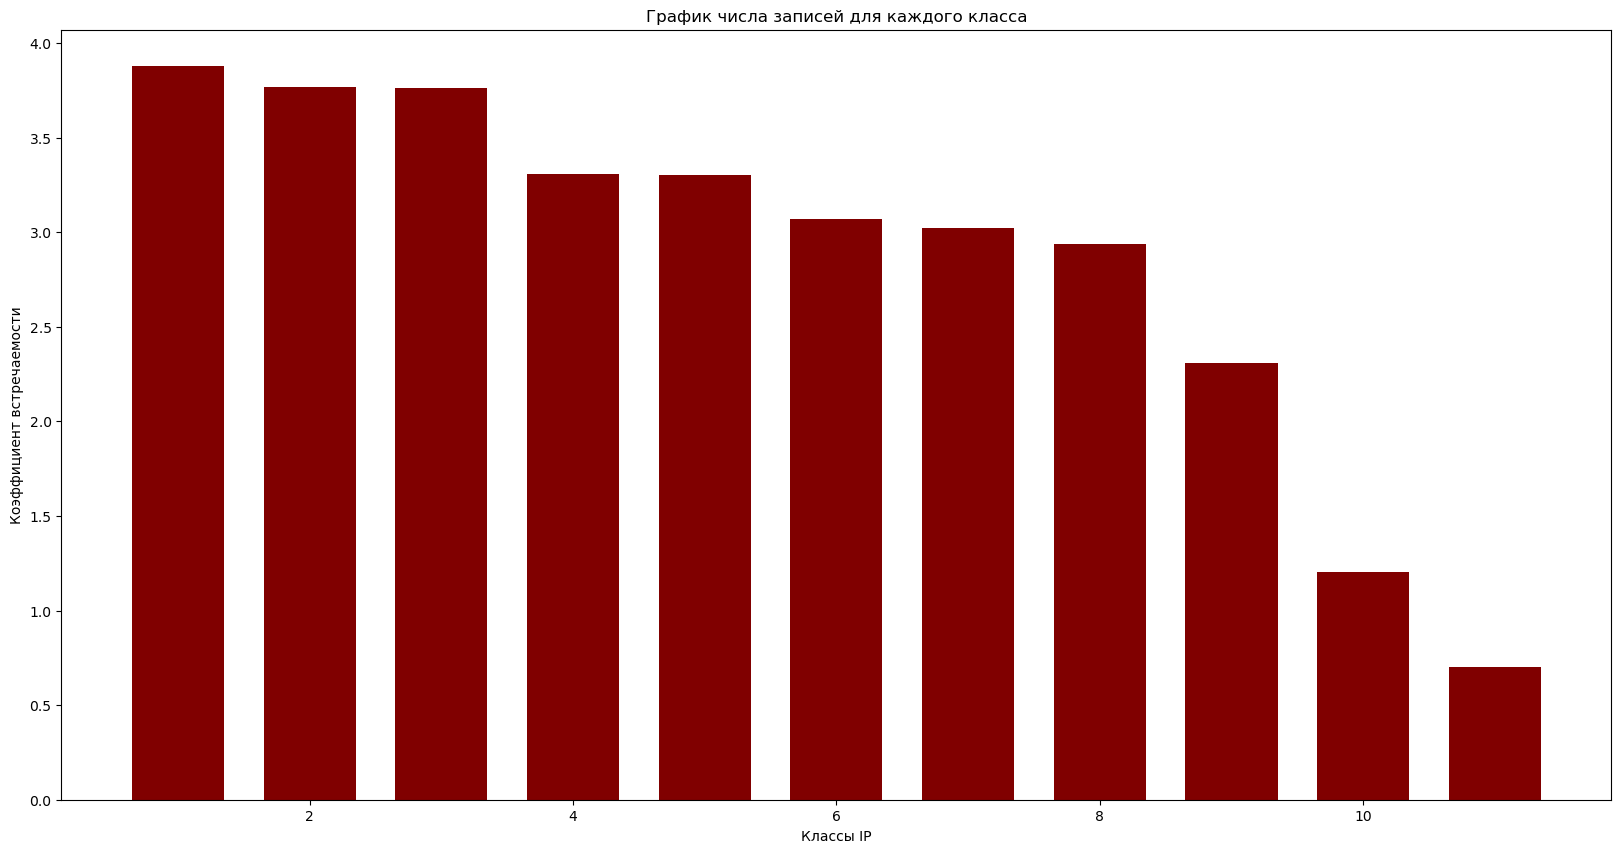

In [33]:
values = []

for cls, ip in enumerate(dataset['sip'].unique()):
    values.append((dataset[dataset['sip'] == ip].shape[0], cls))
    
plot_relative_occurrence(values, "График числа записей для каждого класса")

In [26]:
# Вывод информации о временном охвате каждого IP

for ip in dataset['sip'].unique():
    min_date_time_t = dataset[dataset['sip'] == ip]['tsstart'].min()
    max_date_time_t = dataset[dataset['sip'] == ip]['tsend'].max()
    
    
    min_date_str = strftime('%Y-%m-%d %H:%M', localtime(min_date_time_t))
    max_date_str = strftime('%Y-%m-%d %H:%M', localtime(max_date_time_t))
    
    days_cnt = int(max_date_time_t - min_date_time_t) // (24 * 60 * 60)
    
    print("Для IP " + ip + ": " + min_date_str + " - " + max_date_str + " (" + str(days_cnt) + " дней)")

Для IP 192.168.30.200: 2020-06-24 12:20 - 2020-07-01 12:30 (7 дней)
Для IP 10.90.90.101: 2020-06-24 12:20 - 2020-07-01 12:30 (7 дней)
Для IP 192.168.1.220: 2020-06-24 12:20 - 2020-07-01 12:30 (7 дней)
Для IP 192.168.3.86: 2020-06-24 12:20 - 2020-06-30 16:30 (6 дней)
Для IP 192.168.3.1: 2020-06-24 12:20 - 2020-06-30 16:30 (6 дней)
Для IP 192.168.1.186: 2020-06-24 12:20 - 2020-07-01 12:30 (7 дней)
Для IP 192.168.1.69: 2020-06-24 12:40 - 2020-07-01 11:50 (6 дней)
Для IP 192.168.1.12: 2020-06-25 17:00 - 2020-07-01 12:30 (5 дней)
Для IP 192.168.1.134: 2020-06-24 13:40 - 2020-07-01 09:50 (6 дней)
Для IP 192.168.1.61: 2020-06-25 06:50 - 2020-07-01 10:00 (6 дней)
Для IP 192.168.1.206: 2020-06-29 10:50 - 2020-06-30 18:20 (1 дней)


## Оптимизация по фичам

In [16]:
check_ip = [ "10.90.90.101", "192.168.1.12", "192.168.1.134", "192.168.1.186", "192.168.1.206", "192.168.1.220", "192.168.1.61", "192.168.1.69", "192.168.3.1", "192.168.3.8", "192.168.3.86", "192.168.30.200" ]

dataset = dataset[dataset['sip'].isin(check_ip)]

X = dataset.drop('sip', axis = 1)
y = dataset['sip']

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)
#y = preprocessing.label_binarize(y, classes = dataset['sip'].unique())

try:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y, shuffle = True)
except:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle = True)

In [17]:
# Убираем малозначимые фичи
BATCH_SIZE = 5

files_count = 2

print("SHAPE BEFORE: ", X.shape)

for i in range(1, files_count + 1):
    in_file = open("optimization" + str(i) + ".json")
    sampleJson = json.load(in_file)
    bad_features = jsonpickle.decode(sampleJson)
    
    for feature in bad_features:
        try :
            X = X.drop(feature, axis = 1)
        except KeyError:
            print("1", feature)
            None

        try:
            for i in range(1, BATCH_SIZE + 1):
                new_feature = feature + str(i)
                X = X.drop(new_feature, axis = 1)
        except KeyError:
            print("2", feature)
            None
print("SHAPE AFTER: ", X.shape)

SHAPE BEFORE:  (967953, 1172)
1 stat_in_avrg_bps_80_
1 stat_in_diff_sips_igmp
1 stat_in_avrg_pps_138_
1 stat_in_sum_bytes_138_
1 stat_out_avrg_pps_53_
1 stat_in_diff_prots
1 stat_in_avrg_bpp_icmp
1 stat_in_sum_pkts_igmp
1 stat_in_diff_dports_icmp
1 stat_out_avrg_bps_icmp
1 stat_out_diff_prots_138_
1 stat_in_diff_sips_icmp
1 stat_in_avrg_pps_udp
1 stat_in_diff_sips_80_
1 stat_in_avrg_bps_138_
1 stat_out_conns_cnt_138_
1 stat_in_sum_pkts_138_
1 stat_in_avrg_duration_53_
1 stat_in_avrg_bps_53_
1 stat_out_avrg_duration_80_
1 stat_in_avrg_duration_icmp
2 prot
1 stat_in_sum_pkts_icmp
1 stat_out_avrg_pps_icmp
1 stat_in_avrg_duration_138_
1 stat_out_avrg_bps_igmp
1 stat_in_diff_prots_137_
1 stat_out_avrg_pps_udp
1 stat_in_diff_dports_138_
1 stat_in_sum_bytes_137_
1 stat_in_diff_sips_138_
1 stat_in_conns_cnt_80_
1 stat_in_avrg_bpp_igmp
1 stat_in_avrg_duration_137_
1 stat_in_avrg_bpp_137_
1 stat_out_avrg_bps_53_
1 stat_out_avrg_duration_53_
1 stat_in_avrg_bps_137_
1 stat_out_avrg_duration_138_
1

In [18]:
def eliminate_unimportant_features_sfs(estimator, X, Y, scoring):
    # создаем модель для тестирования
    #estimator, _ = eval_model(X, Y)
    
    # кроссвалидацию будем производить по времени
    #cv = TimeSeriesSplit(n_splits = 10)
    
    # в качестве алгоритма отбора информативных признаков возьмем SFS
    fselector = SFS(estimator, 
                k_features = len(X.columns),
                forward = True, 
                floating = True, 
                scoring = scoring,
                #cv=cv, 
                n_jobs = 28)
    
    # обучаем селектор фич
    fselector.fit(X, Y) #, custom_feature_names = X.columns)
    
    # выводим комбинации фич и результирующую точность
    fstats = pd.DataFrame.from_dict(fselector.get_metric_dict()).T
    fstats.sort_values('avg_score', inplace=True, ascending=False)
    
    print("Среднее значение score лучшей комбинации фич:", fselector.k_score_)
    print("Лучшая комбинация фич:", *fselector.k_feature_names_)
    
    # выводим таблицу комбинаций фич
    display(fstats[:5])
    
    # проверяем на сколько увеличилось качество модели
    #_ = eval_model(fselector.transform(X), Y)

    return list(fselector.k_feature_names_)


def eliminate_unimportant_features_rfecv(estimator, X, Y, scoring):
    # создаем модель для тестирования
    #estimator, _ = eval_model(X, Y)

    # кроссвалидацию будем производить по времени
    #cv = TimeSeriesSplit(n_splits=10)
    
    # рекурсивно удаляем наислабейшие признаки, значимость 
    # которых предварительно рассчитана на разных фолдах
    fselector = RFECV(estimator, 
                      min_features_to_select = 1, 
                      scoring = scoring, 
                      #cv = cv, 
                      n_jobs = 28)
    
    # обучаем селектор фич
    fselector.fit(X, Y)
    
    print()
    print("Среднее значение score лучшей комбинации фич:", fselector.cv_results_['mean_test_score'][fselector.n_features_ - 1])
    print("Лучшая комбинация фич:", *fselector.get_feature_names_out(X.columns))
    
    # выводим средний score модели по всем фолдам для 1,2,3,...n числа фич
    # видим что достаточно использовать k фич, чтобы получить максимальный результат
    #plt.figure(figsize=(16, 6))
    #plt.xlabel('Total features selected')
    #plt.ylabel('Model accuracy')
    #plt.plot(range(1, len(fselector.grid_scores_) + 1), fselector.grid_scores_)
    #plt.show()
    
    # проверяем на сколько увеличилось качество модели
    #_ = eval_model(fselector.transform(X), Y)

    
    return fselector.get_feature_names_out(X.columns).tolist()


In [19]:
def get_bad_features(result, X):
    BATCH_SIZE = 5
    
    bad_features = set()

    for column in X.columns:
        if column not in res1:
            print(column)
            ok = False
            for i in range(1, BATCH_SIZE + 1):
                new_column = list(column)
                new_column[-1] = str(i)
                new_column = "".join(new_column)

                if new_column in res1:
                    ok = True
                    break
            if not ok:
                if column[-1].isdigit():
                    bad_features.add(column[:-1])
                else:
                    bad_features.add(column)
    return bad_features

### RandomForest

In [20]:
rf = RandomForestClassifier(n_jobs = -1, max_depth = 6)

In [21]:
%%time
"""
90 % - aggregated_90_100000_10.pkl
97 % - common_dataset.pkl
"""

res1 = eliminate_unimportant_features_rfecv(rf, X, y, "balanced_accuracy") # "balanced_accuracy 14:04


Среднее значение score лучшей комбинации фич: 0.9747898022301154
Лучшая комбинация фич: sport dport in_conns_cnt1 in_avrg_duration1 in_pkts_sum1 in_bytes_sum1 in_avrg_bps1 in_avrg_pps1 in_avrg_bpp1 in_fin_cnt1 in_syn_cnt1 in_reset_cnt1 in_push_cnt1 in_ack_cnt1 in_urgent_cnt1 in_cwr_cnt1 out_conns_cnt1 out_avrg_duration1 out_pkts_sum1 out_bytes_sum1 out_avrg_bps1 out_avrg_pps1 out_avrg_bpp1 out_fin_cnt1 out_syn_cnt1 out_reset_cnt1 out_push_cnt1 out_ack_cnt1 out_ece_cnt1 out_cwr_cnt1 in_conns_cnt2 in_avrg_duration2 in_pkts_sum2 in_bytes_sum2 in_avrg_bps2 in_avrg_pps2 in_avrg_bpp2 in_fin_cnt2 in_syn_cnt2 in_reset_cnt2 in_push_cnt2 in_ack_cnt2 in_urgent_cnt2 in_cwr_cnt2 out_conns_cnt2 out_avrg_duration2 out_pkts_sum2 out_bytes_sum2 out_avrg_bps2 out_avrg_pps2 out_avrg_bpp2 out_fin_cnt2 out_syn_cnt2 out_reset_cnt2 out_push_cnt2 out_ack_cnt2 out_ece_cnt2 out_cwr_cnt2 in_conns_cnt3 in_avrg_duration3 in_pkts_sum3 in_bytes_sum3 in_avrg_pps3 in_avrg_bpp3 in_fin_cnt3 in_syn_cnt3 in_push_cnt3 out

In [22]:
bad_features = get_bad_features(res1, X)

print(bad_features)

sampleJson = jsonpickle.encode(bad_features)
out_file = open("optimization3.json", "w")

json.dump(sampleJson, out_file)

out_file.close()

in_avrg_bps3
in_reset_cnt3
in_ack_cnt3
in_urgent_cnt3
in_cwr_cnt3
out_avrg_bps3
out_fin_cnt3
out_reset_cnt3
out_push_cnt3
out_ack_cnt3
out_ece_cnt3
out_cwr_cnt3
in_conns_cnt4
in_avrg_bps4
in_avrg_pps4
in_avrg_bpp4
in_fin_cnt4
in_syn_cnt4
in_reset_cnt4
in_ack_cnt4
in_urgent_cnt4
in_cwr_cnt4
out_conns_cnt4
out_avrg_duration4
out_pkts_sum4
out_bytes_sum4
out_avrg_bps4
out_avrg_pps4
out_avrg_bpp4
out_fin_cnt4
out_reset_cnt4
out_push_cnt4
out_ack_cnt4
out_ece_cnt4
out_cwr_cnt4
in_conns_cnt5
in_avrg_duration5
in_pkts_sum5
in_avrg_bps5
in_avrg_pps5
in_fin_cnt5
in_syn_cnt5
in_reset_cnt5
in_push_cnt5
in_ack_cnt5
in_urgent_cnt5
in_cwr_cnt5
out_conns_cnt5
out_avrg_duration5
out_pkts_sum5
out_avrg_bps5
out_avrg_pps5
out_fin_cnt5
out_syn_cnt5
out_reset_cnt5
out_push_cnt5
out_ack_cnt5
out_cwr_cnt5
stat_out_avrg_duration_udp1
stat_out_avrg_bps_udp1
stat_out_conns_cnt_icmp1
stat_out_sum_bytes_icmp1
stat_out_diff_sports_icmp1
stat_out_diff_dips_icmp1
stat_out_diff_dports_icmp1
stat_out_sum_bytes_igmp1


In [21]:
%%time

res2 = eliminate_unimportant_features_sfs(rf, X, y, "balanced_accuracy") # 14:00 - 15:33 NOT FINISHED

/home/jupyter/anaconda3/envs/mlcpu/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Process LokyProcess-236:
Traceback (most recent call last):
  File "/home/jupyter/anaconda3/envs/mlcpu/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/jupyter/anaconda3/envs/mlcpu/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jupyter/anaconda3/envs/mlcpu/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py", line 432, in _process_worker
    with worker_exit_lock:
  File "/home/jupyter/anaconda3/envs/mlcpu/lib/python3.8/site-packages/joblib/externals/loky/backend/synchronize.py", line 110, in __enter__
    return self._semlock.acquire()
KeyboardInterrupt
Process LokyProcess-237:
Trace

AttributeError: SequentialFeatureSelector has not been fitted, yet.

### CatBoost Classifier 

In [15]:
cat_features_name = ['prot', 'sport', 'dport', 'time_of_day']
cat_features_index = [ X.columns.get_loc(feature) for feature in cat_features_name ]

In [16]:
clf = CatBoostClassifier(
    iterations = 5, 
    learning_rate = 0.1, 
    task_type = "CPU",
    #devices='0:1',
    #cat_features = cat_features_index,
    #loss_function='CrossEntropy'
)

In [17]:
%%time

"""
74% - aggregated_90_100000_10.pkl
"""

res_clf = eliminate_unimportant_features_rfecv(clf, X, y, "balanced_accuracy") # "balanced_accuracy 10:02

0:	learn: 1.7661691	total: 3.14s	remaining: 12.6s
1:	learn: 1.4838722	total: 6.26s	remaining: 9.39s
2:	learn: 1.2789142	total: 9.46s	remaining: 6.31s
3:	learn: 1.1223439	total: 12.3s	remaining: 3.09s
4:	learn: 1.0079464	total: 15.1s	remaining: 0us
0:	learn: 1.7617064	total: 1.66s	remaining: 6.66s
1:	learn: 1.4814308	total: 4.49s	remaining: 6.74s
2:	learn: 1.2703658	total: 6.78s	remaining: 4.52s
3:	learn: 1.1165057	total: 9.11s	remaining: 2.28s
4:	learn: 1.0013649	total: 11.3s	remaining: 0us
0:	learn: 1.7667082	total: 1.18s	remaining: 4.73s
1:	learn: 1.4810685	total: 2.87s	remaining: 4.3s
2:	learn: 1.2977562	total: 5.33s	remaining: 3.56s
3:	learn: 1.1358195	total: 7.84s	remaining: 1.96s
4:	learn: 1.0178224	total: 10.3s	remaining: 0us
0:	learn: 1.7659177	total: 999ms	remaining: 4s
1:	learn: 1.4857169	total: 2.59s	remaining: 3.89s
2:	learn: 1.2974950	total: 4.56s	remaining: 3.04s
3:	learn: 1.1396370	total: 6.94s	remaining: 1.74s
4:	learn: 1.0160557	total: 9.32s	remaining: 0us
0:	learn: 1.

0:	learn: 1.8127163	total: 3.04s	remaining: 12.1s
1:	learn: 1.5376023	total: 5.88s	remaining: 8.82s
2:	learn: 1.3580022	total: 9.25s	remaining: 6.17s
3:	learn: 1.2155173	total: 12.3s	remaining: 3.08s
4:	learn: 1.1022551	total: 14.9s	remaining: 0us
0:	learn: 1.8091648	total: 1.63s	remaining: 6.51s
1:	learn: 1.5436375	total: 4.2s	remaining: 6.3s
2:	learn: 1.3560233	total: 7.17s	remaining: 4.78s
3:	learn: 1.2172761	total: 10s	remaining: 2.5s
4:	learn: 1.1088389	total: 11.9s	remaining: 0us
0:	learn: 1.8087836	total: 1.73s	remaining: 6.92s
1:	learn: 1.5455280	total: 4.36s	remaining: 6.53s
2:	learn: 1.3624073	total: 6.86s	remaining: 4.57s
3:	learn: 1.2203159	total: 9.04s	remaining: 2.26s
4:	learn: 1.1061415	total: 10.7s	remaining: 0us
0:	learn: 1.8140287	total: 1.66s	remaining: 6.63s
1:	learn: 1.5380818	total: 4.11s	remaining: 6.16s
2:	learn: 1.3575994	total: 6.73s	remaining: 4.49s
3:	learn: 1.2187861	total: 8.44s	remaining: 2.11s
4:	learn: 1.1081431	total: 10.4s	remaining: 0us
0:	learn: 1.8

0:	learn: 1.8421119	total: 3.24s	remaining: 13s
1:	learn: 1.5659972	total: 6.81s	remaining: 10.2s
2:	learn: 1.3741893	total: 10.3s	remaining: 6.88s
3:	learn: 1.2293390	total: 13.3s	remaining: 3.32s
4:	learn: 1.1207847	total: 14.9s	remaining: 0us
0:	learn: 1.8490291	total: 3.06s	remaining: 12.2s
1:	learn: 1.5663848	total: 5.53s	remaining: 8.29s
2:	learn: 1.3848130	total: 7.99s	remaining: 5.33s
3:	learn: 1.2350196	total: 9.92s	remaining: 2.48s
4:	learn: 1.1229870	total: 10.9s	remaining: 0us
0:	learn: 1.8506009	total: 2.49s	remaining: 9.97s
1:	learn: 1.5554483	total: 4.98s	remaining: 7.46s
2:	learn: 1.3709695	total: 7s	remaining: 4.67s
3:	learn: 1.2314546	total: 8.52s	remaining: 2.13s
4:	learn: 1.1208938	total: 9.59s	remaining: 0us
0:	learn: 1.8483621	total: 2.58s	remaining: 10.3s
1:	learn: 1.5605094	total: 4.66s	remaining: 6.99s
2:	learn: 1.3661529	total: 6.84s	remaining: 4.56s
3:	learn: 1.2230472	total: 8.38s	remaining: 2.09s
4:	learn: 1.1121325	total: 9.78s	remaining: 0us
0:	learn: 1.8

0:	learn: 1.8425285	total: 981ms	remaining: 3.92s
1:	learn: 1.5442385	total: 2.33s	remaining: 3.5s
2:	learn: 1.3554368	total: 3.74s	remaining: 2.49s
3:	learn: 1.2155410	total: 5.63s	remaining: 1.41s
4:	learn: 1.1031271	total: 7.25s	remaining: 0us
0:	learn: 1.8425285	total: 771ms	remaining: 3.08s
1:	learn: 1.5442385	total: 1.5s	remaining: 2.25s
2:	learn: 1.3554368	total: 2.3s	remaining: 1.53s
3:	learn: 1.2155410	total: 3.69s	remaining: 924ms
4:	learn: 1.1031271	total: 5.45s	remaining: 0us
0:	learn: 1.8480043	total: 1.1s	remaining: 4.41s
1:	learn: 1.5504731	total: 1.91s	remaining: 2.86s
2:	learn: 1.3585456	total: 2.79s	remaining: 1.86s
3:	learn: 1.2139331	total: 3.56s	remaining: 890ms
4:	learn: 1.1032067	total: 4.79s	remaining: 0us
0:	learn: 1.8480043	total: 1.99s	remaining: 7.95s
1:	learn: 1.5504731	total: 3.25s	remaining: 4.88s
2:	learn: 1.3585456	total: 4.15s	remaining: 2.76s
3:	learn: 1.2139331	total: 4.87s	remaining: 1.22s
4:	learn: 1.1032067	total: 5.75s	remaining: 0us
0:	learn: 1.

0:	learn: 1.8256372	total: 1.17s	remaining: 4.68s
1:	learn: 1.5335293	total: 2.59s	remaining: 3.88s
2:	learn: 1.3450645	total: 4.53s	remaining: 3.02s
3:	learn: 1.2037255	total: 6.57s	remaining: 1.64s
4:	learn: 1.0990232	total: 8.9s	remaining: 0us
0:	learn: 1.8256372	total: 1.17s	remaining: 4.69s
1:	learn: 1.5335293	total: 2.57s	remaining: 3.86s
2:	learn: 1.3450645	total: 4.49s	remaining: 3s
3:	learn: 1.2037255	total: 6.5s	remaining: 1.62s
4:	learn: 1.0990232	total: 8.56s	remaining: 0us
0:	learn: 1.8282237	total: 1.53s	remaining: 6.12s
1:	learn: 1.5443993	total: 3.52s	remaining: 5.29s
2:	learn: 1.3554312	total: 5.68s	remaining: 3.79s
3:	learn: 1.2115456	total: 7.81s	remaining: 1.95s
4:	learn: 1.0975877	total: 9.18s	remaining: 0us
0:	learn: 1.8282237	total: 1.71s	remaining: 6.82s
1:	learn: 1.5443993	total: 3.99s	remaining: 5.99s
2:	learn: 1.3554312	total: 6.09s	remaining: 4.06s
3:	learn: 1.2115456	total: 7.95s	remaining: 1.99s
4:	learn: 1.0975877	total: 9.09s	remaining: 0us
0:	learn: 1.8

0:	learn: 1.7646158	total: 705ms	remaining: 2.82s
1:	learn: 1.4565602	total: 1.55s	remaining: 2.32s
2:	learn: 1.2535555	total: 2.6s	remaining: 1.73s
3:	learn: 1.1121239	total: 3.91s	remaining: 977ms
4:	learn: 1.0040203	total: 5.54s	remaining: 0us
0:	learn: 1.7642009	total: 952ms	remaining: 3.81s
1:	learn: 1.4787140	total: 1.86s	remaining: 2.79s
2:	learn: 1.2967287	total: 2.33s	remaining: 1.55s
3:	learn: 1.1343963	total: 3.19s	remaining: 798ms
4:	learn: 1.0177869	total: 4.48s	remaining: 0us
0:	learn: 1.7679136	total: 1.5s	remaining: 6.01s
1:	learn: 1.4811100	total: 2.54s	remaining: 3.81s
2:	learn: 1.2704277	total: 3.26s	remaining: 2.17s
3:	learn: 1.1325439	total: 4.1s	remaining: 1.02s
4:	learn: 1.0126997	total: 5.07s	remaining: 0us
0:	learn: 1.7642009	total: 1.03s	remaining: 4.13s
1:	learn: 1.4785855	total: 2.73s	remaining: 4.1s
2:	learn: 1.2696842	total: 3.96s	remaining: 2.64s
3:	learn: 1.1220626	total: 4.83s	remaining: 1.21s
4:	learn: 1.0020173	total: 5.89s	remaining: 0us
0:	learn: 1.

1:	learn: 1.5387492	total: 2.49s	remaining: 3.74s
2:	learn: 1.3584818	total: 3.42s	remaining: 2.28s
3:	learn: 1.2157680	total: 4.41s	remaining: 1.1s
4:	learn: 1.1021894	total: 5.57s	remaining: 0us
0:	learn: 1.8100550	total: 1.23s	remaining: 4.92s
1:	learn: 1.5418433	total: 2.29s	remaining: 3.43s
2:	learn: 1.3562655	total: 3.26s	remaining: 2.18s
3:	learn: 1.2076768	total: 4.34s	remaining: 1.09s
4:	learn: 1.0955558	total: 5.25s	remaining: 0us
0:	learn: 1.8155916	total: 1.04s	remaining: 4.14s
1:	learn: 1.5395545	total: 2.38s	remaining: 3.57s
2:	learn: 1.3502307	total: 3.42s	remaining: 2.28s
3:	learn: 1.2042233	total: 4.71s	remaining: 1.18s
4:	learn: 1.0943320	total: 5.74s	remaining: 0us
0:	learn: 1.8091648	total: 966ms	remaining: 3.86s
1:	learn: 1.5403086	total: 1.99s	remaining: 2.98s
2:	learn: 1.3533119	total: 2.92s	remaining: 1.95s
3:	learn: 1.2199653	total: 3.69s	remaining: 923ms
4:	learn: 1.1115825	total: 4.38s	remaining: 0us
0:	learn: 1.8087836	total: 1.29s	remaining: 5.15s
1:	learn:

1:	learn: 1.5670848	total: 1.26s	remaining: 1.89s
2:	learn: 1.3810717	total: 2.1s	remaining: 1.4s
3:	learn: 1.2300891	total: 3.4s	remaining: 849ms
4:	learn: 1.1220773	total: 4.93s	remaining: 0us
0:	learn: 1.8428369	total: 722ms	remaining: 2.89s
1:	learn: 1.5665311	total: 1.38s	remaining: 2.07s
2:	learn: 1.3736659	total: 2.13s	remaining: 1.42s
3:	learn: 1.2305006	total: 3.08s	remaining: 770ms
4:	learn: 1.1211058	total: 4.61s	remaining: 0us
0:	learn: 1.8485539	total: 769ms	remaining: 3.08s
1:	learn: 1.5601868	total: 1.55s	remaining: 2.32s
2:	learn: 1.3795480	total: 2.47s	remaining: 1.65s
3:	learn: 1.2306122	total: 3.58s	remaining: 894ms
4:	learn: 1.1223635	total: 5.31s	remaining: 0us
0:	learn: 1.8295121	total: 907ms	remaining: 3.63s
1:	learn: 1.5627453	total: 1.77s	remaining: 2.66s
2:	learn: 1.3730723	total: 2.72s	remaining: 1.81s
3:	learn: 1.2291929	total: 3.6s	remaining: 901ms
4:	learn: 1.1179187	total: 5.18s	remaining: 0us
0:	learn: 1.8508905	total: 1.15s	remaining: 4.6s
1:	learn: 1.5

0:	learn: 1.8412238	total: 1.08s	remaining: 4.3s
1:	learn: 1.5466048	total: 2.14s	remaining: 3.21s
2:	learn: 1.3532475	total: 3.11s	remaining: 2.07s
3:	learn: 1.2104554	total: 3.82s	remaining: 955ms
4:	learn: 1.1029694	total: 4.38s	remaining: 0us
0:	learn: 1.8416011	total: 959ms	remaining: 3.84s
1:	learn: 1.5468069	total: 2.02s	remaining: 3.02s
2:	learn: 1.3588564	total: 3.05s	remaining: 2.04s
3:	learn: 1.2126371	total: 3.75s	remaining: 937ms
4:	learn: 1.1029900	total: 4.15s	remaining: 0us
0:	learn: 1.8388930	total: 865ms	remaining: 3.46s
1:	learn: 1.5469420	total: 2.01s	remaining: 3.02s
2:	learn: 1.3595073	total: 3.15s	remaining: 2.1s
3:	learn: 1.2235148	total: 3.94s	remaining: 985ms
4:	learn: 1.1096539	total: 4.57s	remaining: 0us
0:	learn: 1.8377882	total: 895ms	remaining: 3.58s
1:	learn: 1.5487133	total: 1.8s	remaining: 2.7s
2:	learn: 1.3518324	total: 2.76s	remaining: 1.84s
3:	learn: 1.2127341	total: 3.6s	remaining: 899ms
4:	learn: 1.1037945	total: 4.5s	remaining: 0us
0:	learn: 1.83

0:	learn: 1.8267596	total: 567ms	remaining: 2.27s
1:	learn: 1.5474854	total: 1.25s	remaining: 1.87s
2:	learn: 1.3531195	total: 2.05s	remaining: 1.37s
3:	learn: 1.2146356	total: 3.13s	remaining: 782ms
4:	learn: 1.1067475	total: 3.95s	remaining: 0us
0:	learn: 1.8256372	total: 569ms	remaining: 2.27s
1:	learn: 1.5429524	total: 1.11s	remaining: 1.67s
2:	learn: 1.3544292	total: 1.87s	remaining: 1.25s
3:	learn: 1.2071752	total: 2.96s	remaining: 740ms
4:	learn: 1.0971544	total: 3.84s	remaining: 0us
0:	learn: 1.8256372	total: 555ms	remaining: 2.22s
1:	learn: 1.5334186	total: 1.09s	remaining: 1.63s
2:	learn: 1.3489675	total: 1.9s	remaining: 1.26s
3:	learn: 1.2118980	total: 2.88s	remaining: 719ms
4:	learn: 1.1058644	total: 3.74s	remaining: 0us
0:	learn: 1.8170606	total: 729ms	remaining: 2.91s
1:	learn: 1.5343453	total: 1.28s	remaining: 1.92s
2:	learn: 1.3516018	total: 2.2s	remaining: 1.47s
3:	learn: 1.2096309	total: 3.07s	remaining: 767ms
4:	learn: 1.0977045	total: 4.11s	remaining: 0us
0:	learn: 

0:	learn: 1.8319992	total: 748ms	remaining: 2.99s
1:	learn: 1.5452558	total: 1.38s	remaining: 2.08s
2:	learn: 1.3506211	total: 2.01s	remaining: 1.34s
3:	learn: 1.2065198	total: 2.64s	remaining: 659ms
4:	learn: 1.1006119	total: 3.28s	remaining: 0us
0:	learn: 1.8331536	total: 1s	remaining: 4.02s
1:	learn: 1.5396412	total: 1.67s	remaining: 2.51s
2:	learn: 1.3548524	total: 2.31s	remaining: 1.54s
3:	learn: 1.2111017	total: 2.96s	remaining: 739ms
4:	learn: 1.0986509	total: 3.6s	remaining: 0us
0:	learn: 1.8364427	total: 684ms	remaining: 2.73s
1:	learn: 1.5388599	total: 1.3s	remaining: 1.96s
2:	learn: 1.3464633	total: 2.07s	remaining: 1.38s
3:	learn: 1.2061930	total: 2.69s	remaining: 674ms
4:	learn: 1.1003339	total: 3.31s	remaining: 0us
0:	learn: 1.8359302	total: 673ms	remaining: 2.69s
1:	learn: 1.5390968	total: 1.31s	remaining: 1.97s
2:	learn: 1.3486271	total: 2.01s	remaining: 1.34s
3:	learn: 1.2112140	total: 2.63s	remaining: 657ms
4:	learn: 1.1015242	total: 3.25s	remaining: 0us
0:	learn: 1.8

1:	learn: 1.5391764	total: 1.14s	remaining: 1.71s
2:	learn: 1.3478204	total: 1.7s	remaining: 1.13s
3:	learn: 1.2108956	total: 2.27s	remaining: 567ms
4:	learn: 1.0979847	total: 2.84s	remaining: 0us
0:	learn: 1.8361567	total: 605ms	remaining: 2.42s
1:	learn: 1.5391764	total: 1.19s	remaining: 1.78s
2:	learn: 1.3478204	total: 1.75s	remaining: 1.17s
3:	learn: 1.2108956	total: 2.32s	remaining: 579ms
4:	learn: 1.0979847	total: 2.89s	remaining: 0us
0:	learn: 1.8353568	total: 574ms	remaining: 2.29s
1:	learn: 1.5418749	total: 1.13s	remaining: 1.69s
2:	learn: 1.3528993	total: 1.7s	remaining: 1.13s
3:	learn: 1.2097657	total: 2.27s	remaining: 568ms
4:	learn: 1.0982444	total: 2.82s	remaining: 0us
0:	learn: 1.8353568	total: 553ms	remaining: 2.21s
1:	learn: 1.5418749	total: 1.11s	remaining: 1.66s
2:	learn: 1.3528993	total: 1.65s	remaining: 1.1s
3:	learn: 1.2097657	total: 2.21s	remaining: 552ms
4:	learn: 1.0982444	total: 2.76s	remaining: 0us
0:	learn: 1.8329519	total: 556ms	remaining: 2.22s
1:	learn: 1

0:	learn: 1.8344617	total: 394ms	remaining: 1.57s
1:	learn: 1.5441431	total: 952ms	remaining: 1.43s
2:	learn: 1.3541992	total: 1.46s	remaining: 976ms
3:	learn: 1.2131726	total: 2s	remaining: 500ms
4:	learn: 1.1040555	total: 2.53s	remaining: 0us
0:	learn: 1.8513049	total: 567ms	remaining: 2.27s
1:	learn: 1.5573953	total: 1.05s	remaining: 1.58s
2:	learn: 1.3687545	total: 1.57s	remaining: 1.05s
3:	learn: 1.2301726	total: 1.97s	remaining: 492ms
4:	learn: 1.1174293	total: 2.39s	remaining: 0us
0:	learn: 1.8377882	total: 509ms	remaining: 2.03s
1:	learn: 1.5496618	total: 1.11s	remaining: 1.66s
2:	learn: 1.3565572	total: 1.67s	remaining: 1.11s
3:	learn: 1.2131398	total: 2.05s	remaining: 514ms
4:	learn: 1.1021712	total: 2.77s	remaining: 0us
0:	learn: 1.8377882	total: 487ms	remaining: 1.95s
1:	learn: 1.5454653	total: 939ms	remaining: 1.41s
2:	learn: 1.3557481	total: 1.44s	remaining: 959ms
3:	learn: 1.2134585	total: 1.91s	remaining: 477ms
4:	learn: 1.1027003	total: 2.33s	remaining: 0us
0:	learn: 1

0:	learn: 1.8299696	total: 399ms	remaining: 1.59s
1:	learn: 1.5306883	total: 865ms	remaining: 1.3s
2:	learn: 1.3484633	total: 1.44s	remaining: 958ms
3:	learn: 1.2076511	total: 1.99s	remaining: 497ms
4:	learn: 1.0998103	total: 2.53s	remaining: 0us
0:	learn: 1.8270819	total: 389ms	remaining: 1.55s
1:	learn: 1.5459838	total: 943ms	remaining: 1.41s
2:	learn: 1.3547683	total: 1.42s	remaining: 948ms
3:	learn: 1.2112693	total: 1.97s	remaining: 493ms
4:	learn: 1.0982738	total: 2.47s	remaining: 0us
0:	learn: 1.8170606	total: 338ms	remaining: 1.35s
1:	learn: 1.5387132	total: 739ms	remaining: 1.11s
2:	learn: 1.3525175	total: 1.22s	remaining: 811ms
3:	learn: 1.2071053	total: 1.69s	remaining: 423ms
4:	learn: 1.0968562	total: 2.17s	remaining: 0us
0:	learn: 1.8170606	total: 486ms	remaining: 1.94s
1:	learn: 1.5385325	total: 895ms	remaining: 1.34s
2:	learn: 1.3527939	total: 1.28s	remaining: 857ms
3:	learn: 1.2117756	total: 1.8s	remaining: 449ms
4:	learn: 1.0956658	total: 2.23s	remaining: 0us
0:	learn: 

In [18]:
bad_features = get_bad_features(res_clf, X)

print(bad_features)

in_urgent_cnt1
out_urgent_cnt1
out_cwr_cnt1
out_urgent_cnt2
out_ece_cnt2
out_cwr_cnt2
in_urgent_cnt3
in_cwr_cnt3
out_urgent_cnt3
out_ece_cnt3
out_cwr_cnt3
in_urgent_cnt4
in_cwr_cnt4
out_urgent_cnt4
out_ece_cnt4
out_cwr_cnt4
out_urgent_cnt5
out_ece_cnt5
{'out_urgent_cnt'}


## Обучение моделей

### RandomForest

In [10]:
X_train = sel.transform(X_train)
X_test = sel.transform(X_test)

In [ ]:
# Number of trees in random forest
n_estimators = [val for val in range(50, 500, 50)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [6, 8, 10, 12]
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Создадим сетку параметров
param_grid = { 'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap }

In [18]:
%%time
# https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py
rf = RandomForestClassifier(n_jobs = 16, max_depth = 6)
#rf_RandomGrid = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv = 2, verbose=2, n_jobs = 6, n_iter = 2)
#rf_RandomGrid.fit(X_train, y_train)
rf.fit(X_train, y_train)

<timed exec>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


CPU times: user 10.8 s, sys: 123 ms, total: 10.9 s
Wall time: 1.66 s


RandomForestClassifier(max_depth=6, n_jobs=16)

In [100]:
print(X_train.shape)

(7949097, 155)


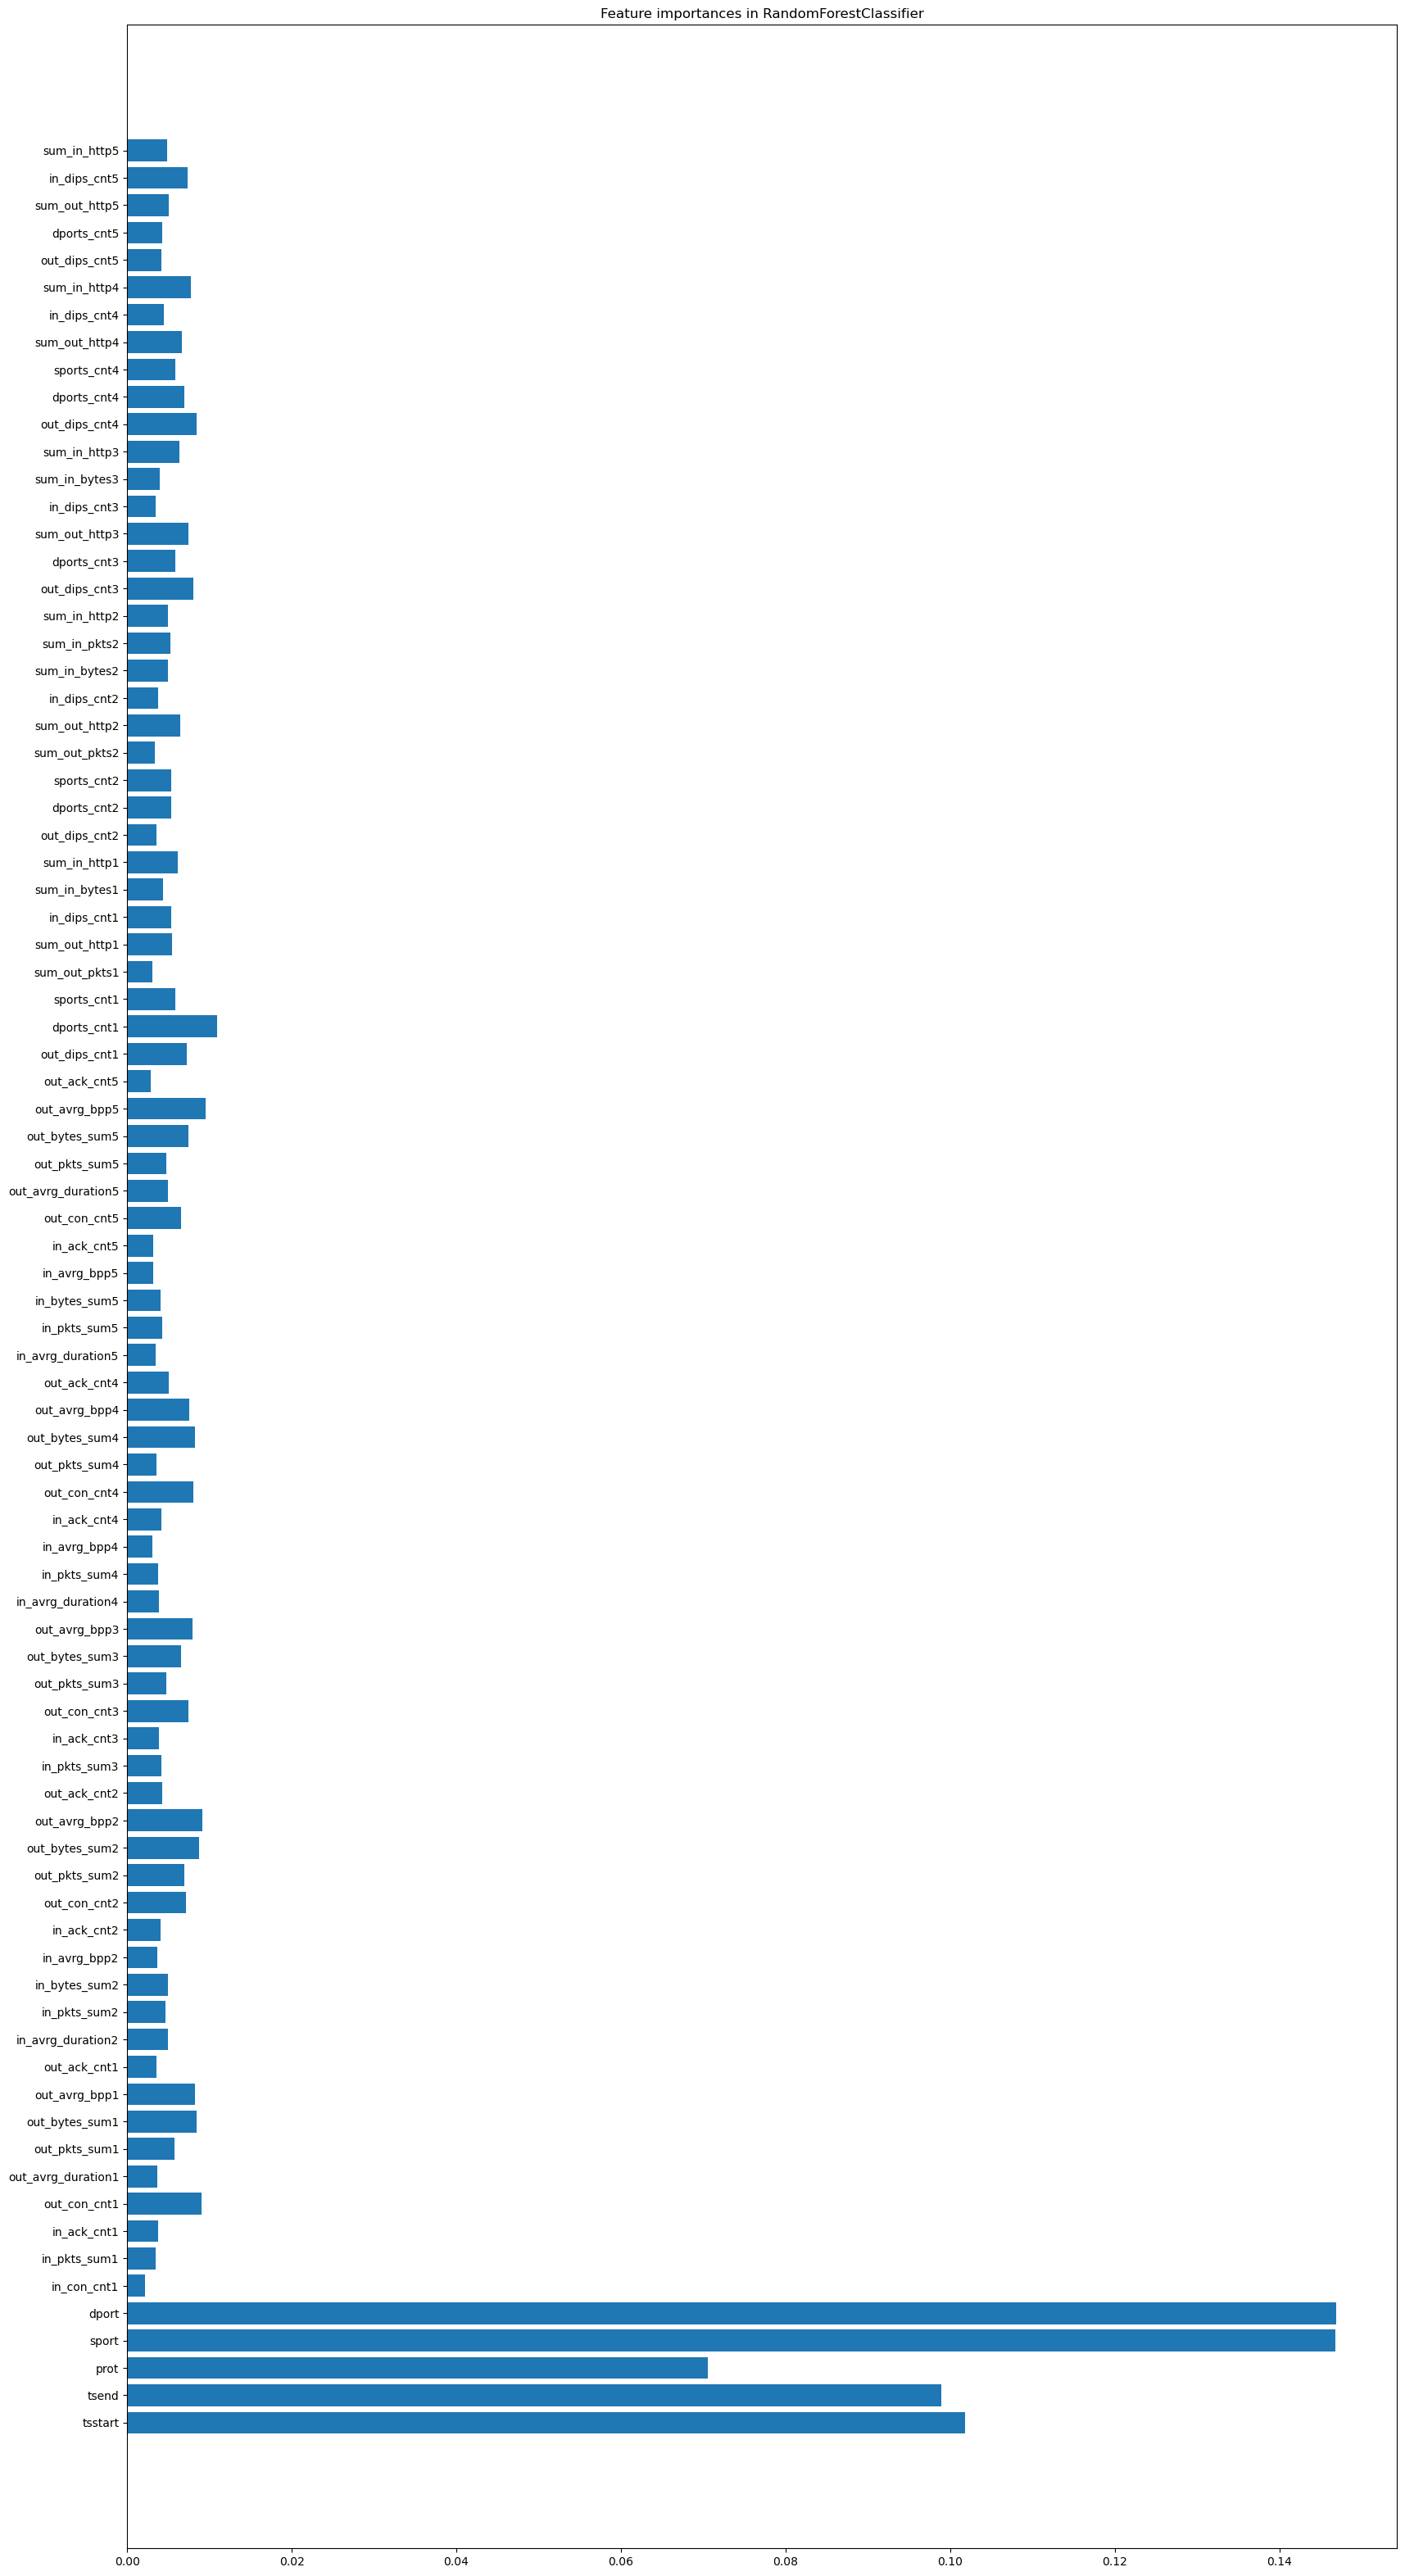

In [13]:
plt.figure(figsize=(20,40))
plt.barh(selected_feat, rf.feature_importances_)
plt.title("Feature importances in RandomForestClassifier")
plt.show()

In [ ]:
rf_RandomGrid.best_params_

In [101]:
%%time

"""
    Результаты обучения на различных датасетах:
        НОВЫЙ ДАТАСЕТ:
           1. onedirectional:
            1) aggregated_100000.pkl - 0.06
            2) uniform_1000000_quantile_0.95_removed.pkl - 0.15
            3) another_1000000_quantile_0.95_removed.pkl - 0.26
            4) aggregated2_100000_10.pkl - 0.11
            5) smoted_100000_with_cnt_only_100000_quantile_0.95_removed.pkl - 0.31
            6) result_dataset.pkl - 0.08 (+ 0.22)
            7) aggregated3_100000_quantile_0.95_removed.pkl - 0.29 (ПОСЛЕ ОПТИМИЗАЦИИ ПО ФИЧАМ - 0.25)
            8) result_dataset_NEW_smoted_100000_with_cnt_only_100000_.pkl - (ПОСЛЕ ОПТИМИЗАЦИИ ПО ФИЧАМ) 0.30
        
"""

preds = rf.predict(X_test)
score = balanced_accuracy_score(y_test, preds)
print("Точность предсказания модели составляет: ", score)

Точность предсказания модели составляет:  0.2444135913416072
CPU times: user 1min 27s, sys: 28.3 s, total: 1min 56s
Wall time: 34.3 s


In [30]:
pickle.dump(rf, open('/data/jupyter/prianikq/trained_models/rf_' + DATASET_NAME[:-4] + '.sav', 'wb'))

In [102]:
cm = confusion_matrix(y_true = y_test, y_pred = preds, labels = le.transform(le.classes_))

FP = cm.sum(axis = 0) - np.diag(cm) 
FN = cm.sum(axis = 1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Доля истинно положительных результатов
TPR = TP / (TP + FN)

# Истинная отрицательная ставка
TNR = TN / (TN + FP) 

# Отрицательное прогностическое значение
NPV = TN / (TN + FN)

# Коэффициент ложных срабатываний
FPR = FP / (FP + TN)

# Уровень ложноотрицательных результатов
FNR = FN / (TP + FN)

# Общая точность
ACC = (TP + TN) / (TP + FP + FN + TN)

In [111]:
"""
IP:
192.168.1.1 - ТКО (только валовый)
192.168.1.125 - DNS (только валовый)
192.168.250.2 - веб-сервер (только валовый)
192.168.250.4 - почтовый сервер (только валовый)
192.168.1.94 - SVN (только валовый)
192.168.1.92 - Клиент1 (все)
192.168.1.45 - Клиент2 (все)
192.168.1.143 - Клиент3 (все)
192.168.1.161 - Клиент4 (все)
"""


for cls, ip in enumerate(le.classes_):
    ip_slice = dataset[dataset['sip'] == ip]
    if ip_slice.shape[0] != 0:
        
        min_date_time_t = ip_slice['tsstart'].min()
        max_date_time_t = ip_slice['tsend'].max()


        min_date_str = strftime('%Y-%m-%d %H:%M', localtime(min_date_time_t))
        max_date_str = strftime('%Y-%m-%d %H:%M', localtime(max_date_time_t))

        days_cnt = int(max_date_time_t - min_date_time_t) // (24 * 60 * 60)
        
        if TPR[cls] > 0.5 and days_cnt > 45:
            print("Для IP " + ip + ": " + min_date_str + " - " + max_date_str + " (" + str(days_cnt) + " дней) (" + str(ip_slice.shape[0]) + " записей) точность предсказания: " + str(TPR[cls]))

Для IP 10.90.90.101: 2020-06-24 12:20 - 2020-09-22 03:10 (89 дней) (25784 записей) точность предсказания: 0.9976726144297905
Для IP 192.168.1.12: 2020-06-25 17:00 - 2020-08-15 12:20 (50 дней) (100000 записей) точность предсказания: 0.5527
Для IP 192.168.1.134: 2020-06-24 13:40 - 2020-09-10 12:20 (77 дней) (100000 записей) точность предсказания: 0.9747
Для IP 192.168.1.186: 2020-06-24 12:20 - 2020-09-22 03:10 (89 дней) (95761 записей) точность предсказания: 0.7718253968253969
Для IP 192.168.1.206: 2020-06-29 10:50 - 2020-09-14 10:40 (76 дней) (100000 записей) точность предсказания: 0.9939
Для IP 192.168.1.220: 2020-06-24 12:20 - 2020-09-22 03:10 (89 дней) (13692 записей) точность предсказания: 0.9284149013878744
Для IP 192.168.1.61: 2020-06-25 06:50 - 2020-09-12 12:20 (79 дней) (100000 записей) точность предсказания: 0.8408
Для IP 192.168.1.69: 2020-06-24 12:40 - 2020-08-27 12:10 (63 дней) (100000 записей) точность предсказания: 0.9342
Для IP 192.168.3.1: 2020-06-24 12:20 - 2020-09-04 1

## Формирование сбалансированных данных

In [17]:
process_dataset = dataset

EACH_IP_SAMPLES = 10000

STRATEGY = 'QUANTILE' # COUNT_ONLY || ACCURACY_ONLY || COUNT_AND_ACCURACY || QUANTILE
QUANTILE_VAL = 0.95
BAD_ACCURACY = 0.1
BAD_CNT = 10000

ZERO_CLS_STRATEGY = 'NO' # 'YES' || 'NO'

SMOTE = 'NO' # 'YES' || 'NO'
SMOTE_STRATEGY = 'COUNT_ONLY' # 'COUNT_ONLY' || 'COUNT_AND_ACCURACY'
SMOTE_BAD_CNT = 100000
SMOTE_BAD_ACCURACY = 0.5

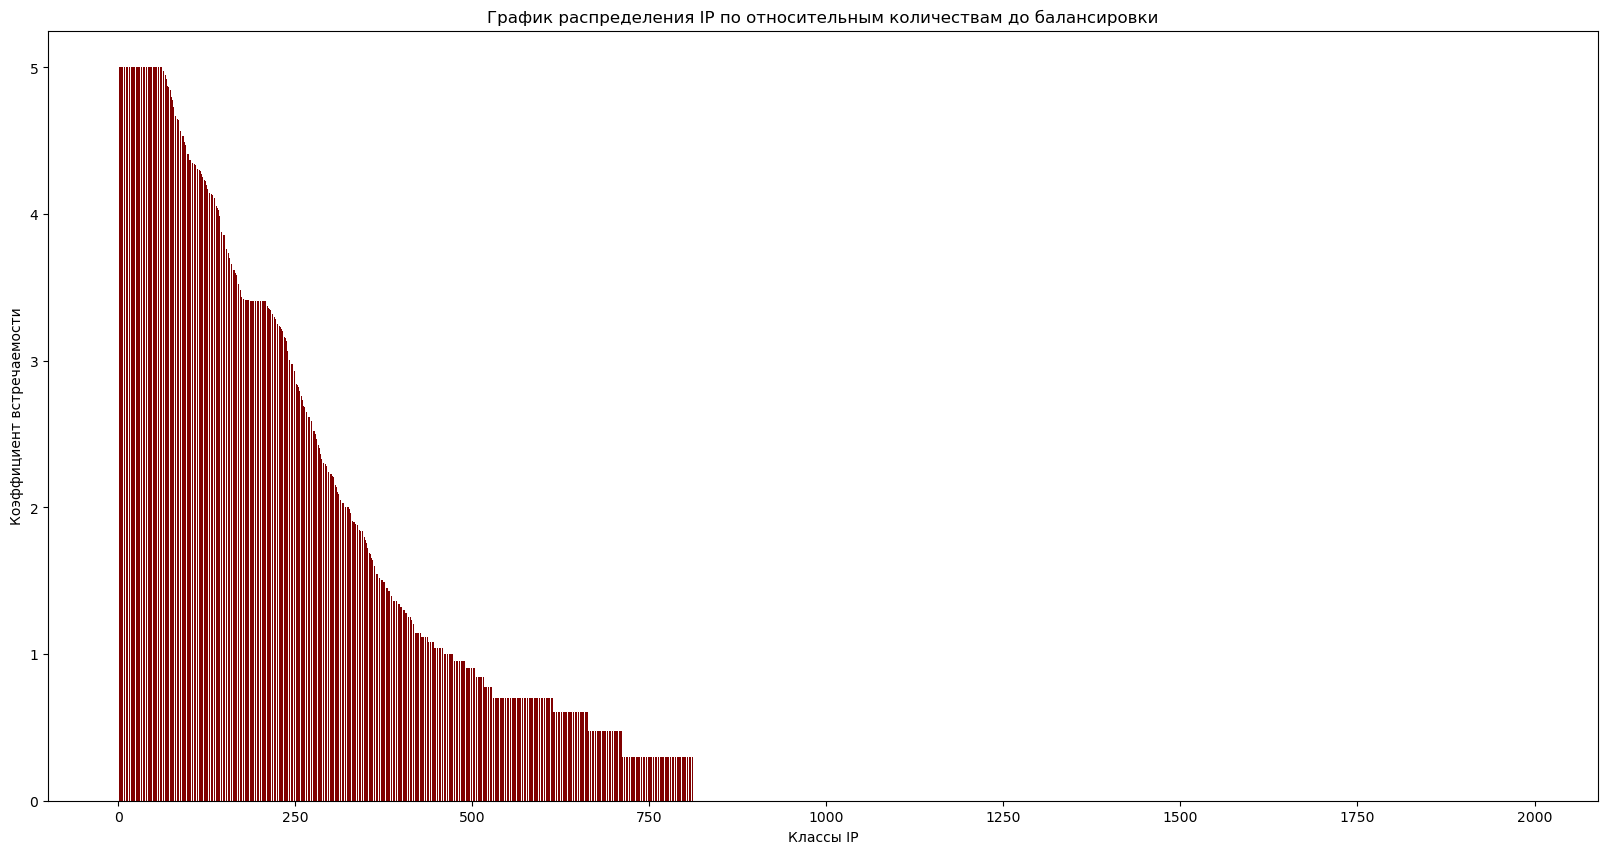

In [17]:
values = []

for cls,ip in enumerate(process_dataset['sip'].unique()):
    values.append((process_dataset[process_dataset['sip'] == ip].shape[0], cls))
    
plot_relative_occurrence(values, "График распределения IP по относительным количествам до балансировки")

In [18]:
summary_cnt = 0
bad_classes = []

for ip, cnt in process_dataset['sip'].value_counts().items():
    cls = le.transform([ip])[0]

    if STRATEGY == 'QUANTILE':
        if summary_cnt / process_dataset.shape[0] < QUANTILE_VAL:
            summary_cnt += cnt
        else:
            bad_classes.append(ip)
    if STRATEGY == 'COUNT_ONLY':
        if cnt < BAD_CNT:
            bad_classes.append(ip)
    elif STRATEGY == 'ACCURACY_ONLY':
        if TPR[cls] < BAD_ACCURACY or math.isnan(TPR[cls]):
            bad_classes.append(ip)
    elif STRATEGY == 'COUNT_AND_ACCURACY':
        if (TPR[cls] < BAD_ACCURACY or math.isnan(TPR[cls])) and cnt < BAD_CNT:
            bad_classes.append(ip)

In [19]:
%%time
# Добавление класса 0 - неизвестный IP

for cls in bad_classes: # Это операция работает слишком долго для датасетов с производными фичами
    process_dataset[process_dataset['sip'] == cls] = '0'
    
if ZERO_CLS_STRATEGY == 'YES':
    print("В результате образования класса неизвестный IP изменено " + str(process_dataset[process_dataset['sip'] == 0].shape[0]) + " записей и " + str(len(bad_classes)) + " классов.")

    sliced_dataset = process_dataset[process_dataset['sip'] == 0].iloc[: (process_dataset[process_dataset['sip'] == 0].shape[0] - (process_dataset[process_dataset['sip'] == 0].shape[0] % EACH_IP_SAMPLES)) : (process_dataset[process_dataset['sip'] == 0].shape[0] // EACH_IP_SAMPLES), :]
    process_dataset.drop( process_dataset[process_dataset['sip'] == 0].index , inplace = True)
    process_dataset = pd.concat([process_dataset, sliced_dataset], axis = 0, ignore_index = True)
    
else:
    before = process_dataset.shape[0]
    process_dataset.drop( process_dataset[process_dataset['sip'] == '0'].index , inplace = True)
    after = process_dataset.shape[0]
    print("В результате удаления убраны " + str(before - after) + " записей и " + str(len(bad_classes)) + " классов.")



В результате удаления убраны 35655 записей и 257 классов.
CPU times: user 21.9 s, sys: 1.74 s, total: 23.7 s
Wall time: 23.7 s


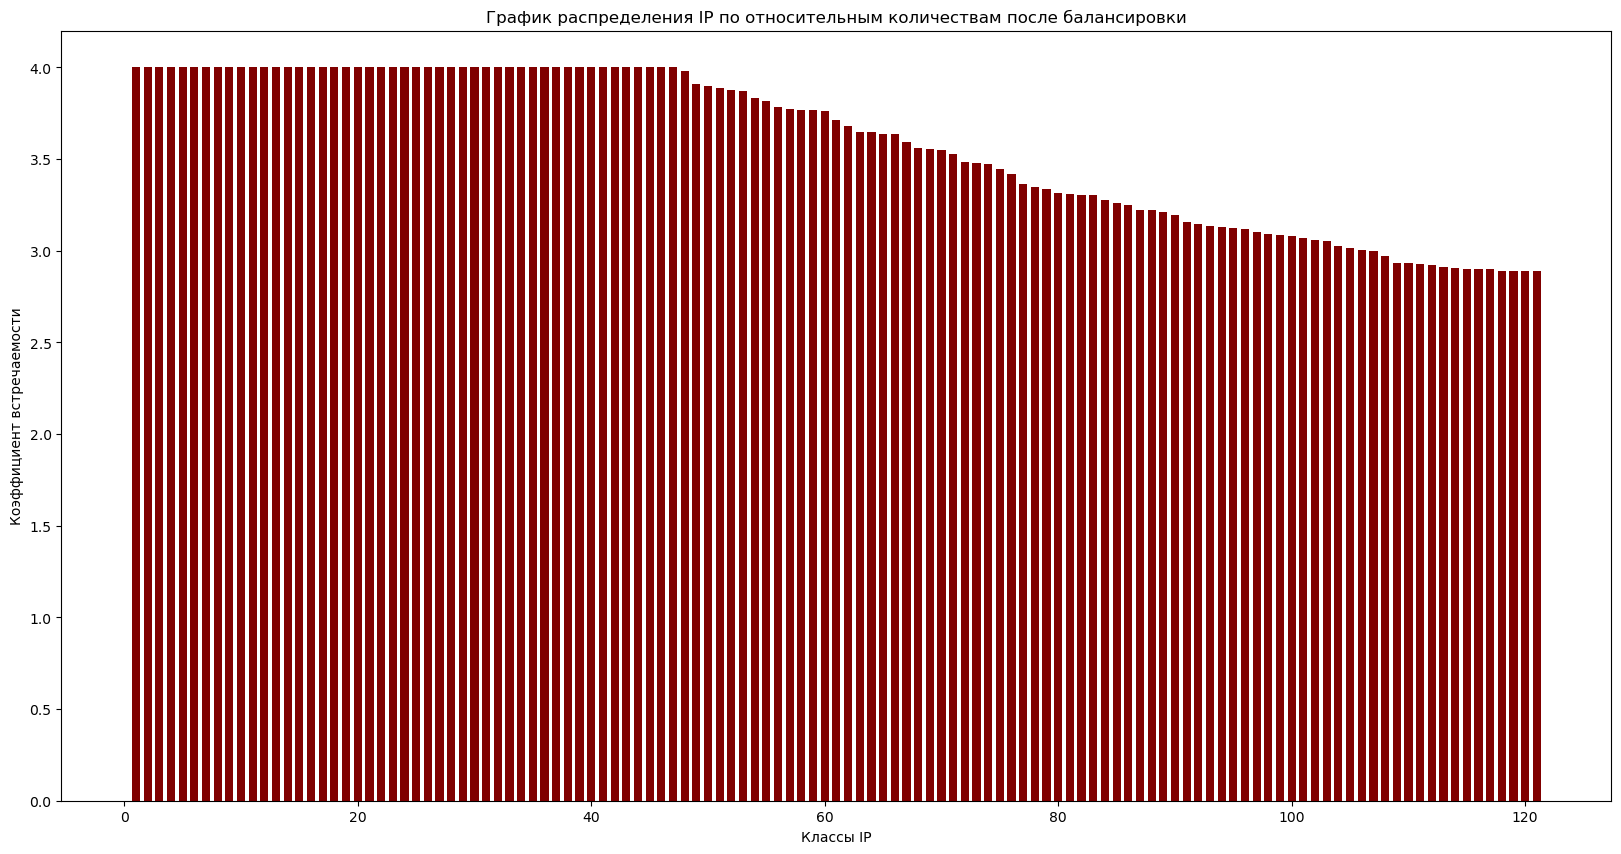

In [20]:
values = []

for cls, ip in enumerate(process_dataset['sip'].unique()):
    values.append((process_dataset[process_dataset['sip'] == ip].shape[0], cls))
    
plot_relative_occurrence(values, "График распределения IP по относительным количествам после балансировки")

In [21]:
# Применение SMOTE и генерация синтетических данных
import imblearn

if SMOTE == 'YES':
    
    smoted_classes = {}
    
    for val, cnt in process_dataset['sip'].value_counts().items():
        if SMOTE_STRATEGY == 'COUNT_ONLY':
            if cnt < SMOTE_BAD_CNT:
                smoted_classes[val] = EACH_IP_SAMPLES
        if SMOTE_STRATEGY == 'COUNT_AND_ACCURACY':
            if cnt < SMOTE_BAD_CNT and (TPR[val - 1] < SMOTE_BAD_ACCURACY or math.isnan(TPR[val - 1])):
                smoted_classes[val] = EACH_IP_SAMPLES
    
    X = process_dataset.drop('sip', axis = 1)
    y = process_dataset['sip']

    smote = imblearn.over_sampling.SMOTE(sampling_strategy = smoted_classes)
    
    X_res, y_res = smote.fit_resample(X, y)
    
    process_dataset = pd.concat([X_res, y_res], axis = 1)


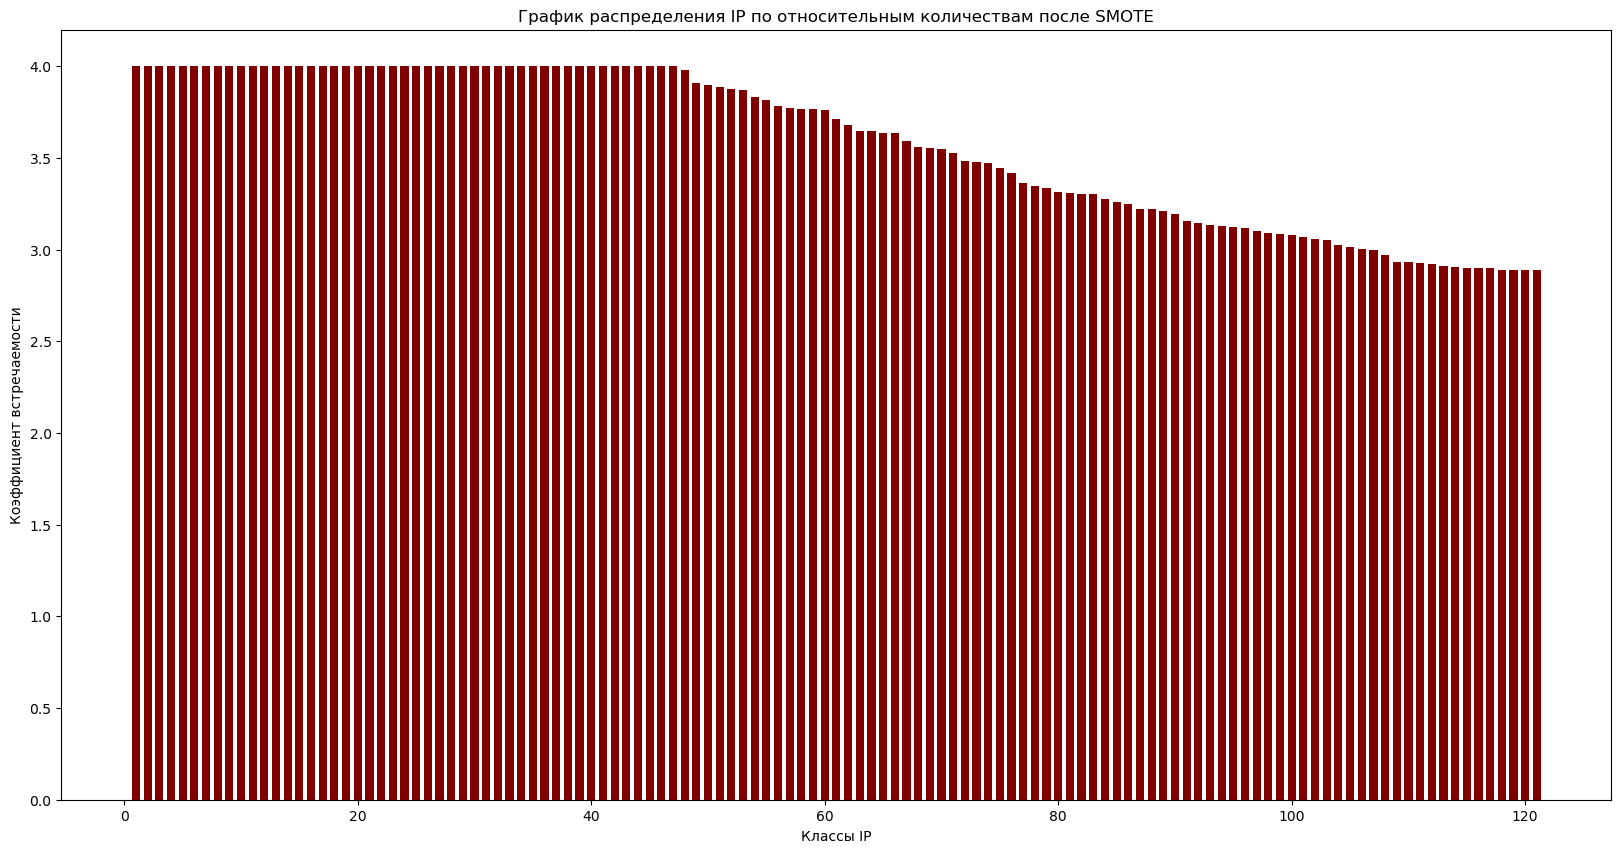

In [22]:
values = []

for cls, ip in enumerate(process_dataset['sip'].unique()):
    values.append((process_dataset[process_dataset['sip'] == ip].shape[0], cls))
    
plot_relative_occurrence(values, "График распределения IP по относительным количествам после SMOTE")

In [23]:
prefix = 'aggregated3_7days_'

if SMOTE == 'NO':
    filename = prefix + str(EACH_IP_SAMPLES) + '_'
else:
    filename = prefix + '_smoted_' + str(EACH_IP_SAMPLES) + '_with_'
    if SMOTE_STRATEGY == 'COUNT_AND_ACCURACY':
        filename += 'cnt_and_acc_' + str(SMOTE_BAD_CNT) + '_' + str(SMOTE_BAD_ACCURACY) + '_'
    elif SMOTE_STRATEGY == 'COUNT_ONLY':
        filename += 'cnt_only_' + str(SMOTE_BAD_CNT) + '_'
        
if STRATEGY != 'NONE':
    if STRATEGY == 'COUNT_ONLY':
        filename += 'cnt_only_' + str(BAD_CNT)
    elif STRATEGY == 'ACCURACY_ONLY':
        filename += 'acc_only_' + str(BAD_ACCURACY)
    elif STRATEGY == 'COUNT_AND_ACCURACY':
        filename += 'cnt_and_acc_' + str(BAD_CNT) + '_' + str(BAD_ACCURACY)
    elif STRATEGY == 'QUANTILE':
        filename += 'quantile_' + str(QUANTILE_VAL)

    if ZERO_CLS_STRATEGY == 'YES':
        filename += '_zero_cls'
    else:
        filename += '_removed'
    
filename += '.pkl'

print("Выходное имя нового датасета: ", filename)

Выходное имя нового датасета:  aggregated3_7days_10000_quantile_0.95_removed.pkl


In [24]:
process_dataset.to_pickle('/data/jupyter/data/proc_csv/onedirectional_csv/balanced_pickle/' + filename)

### XGBClassifier

In [203]:
%%time

"""
    Результаты обучения на различных датасетах:
       1. onedirectional:
        1) uniform_1000000_quantile_0.95_removed.pkl - 0.24
"""

xgb = XGBClassifier(n_jobs = 46)

xgb.fit(X_train, y_train)

CPU times: user 12h 48min 1s, sys: 38min 33s, total: 13h 26min 34s
Wall time: 17min 32s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=46, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
pickle.dump(xgb, open('/data/jupyter/prianikq/trained_models/xgb_classifier1', 'wb'))

In [204]:
y_test = le.fit_transform(y_test)

preds = xgb.predict(X_test)
score = balanced_accuracy_score(y_test, preds)
print("Точность предсказания модели составляет: ", score)

Точность предсказания модели составляет:  0.2424807379783974


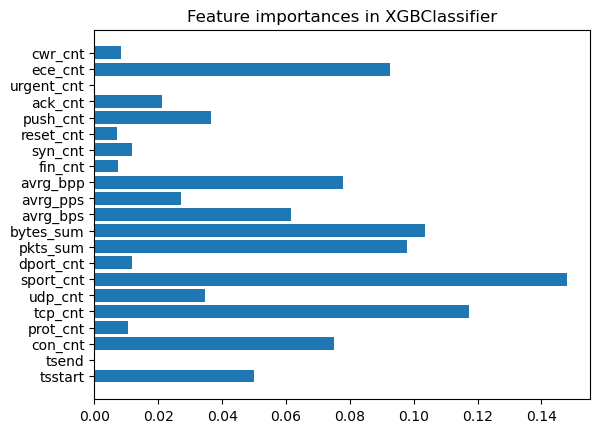

In [205]:
plt.barh(X_train.columns, xgb.feature_importances_)
plt.title("Feature importances in XGBClassifier")
plt.show()

### CatBoost Classifier

In [32]:
cat_features_name = ['prot', 'sport', 'dport', 'time_of_day']
cat_features_index = [ X.columns.get_loc(feature) for feature in cat_features_name ]

In [33]:
clf = CatBoostClassifier(
    iterations = 5, 
    learning_rate = 0.1, 
    task_type = "CPU",
    #devices='0:1',
    #cat_features = cat_features_index,
    #loss_function='CrossEntropy'
)

In [55]:
%%time

clf.fit(X_train, y_train,
        eval_set = (X_test, y_test), 
        verbose = True
)

print(clf.score(X_train, y_train))

print('CatBoost model is fitted: ' + str(clf.is_fitted()))
print('CatBoost model parameters:')
print(clf.get_params())

0:	learn: 1.9139762	test: 1.9152606	best: 1.9152606 (0)	total: 46ms	remaining: 184ms
1:	learn: 1.6699283	test: 1.6714976	best: 1.6714976 (1)	total: 79.3ms	remaining: 119ms
2:	learn: 1.5055303	test: 1.5071718	best: 1.5071718 (2)	total: 114ms	remaining: 75.7ms
3:	learn: 1.3788168	test: 1.3804680	best: 1.3804680 (3)	total: 150ms	remaining: 37.5ms
4:	learn: 1.2815879	test: 1.2832875	best: 1.2832875 (4)	total: 181ms	remaining: 0us
bestTest = 1.283287468
bestIteration = 4
0.7134546356167717
CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 5, 'learning_rate': 0.1, 'task_type': 'GPU', 'devices': '0:1', 'cat_features': [2, 3, 4, 161]}


### Convolutional Variational Autoencoder

In [4]:
disable_eager_execution()

In [5]:
# Выполним небольшую предобработку
# Удалим классы из валидационной выборки, которых нету в тренировочной

train_classes = np.unique(y_train)
test_classes = np.unique(y_test)

for cls in test_classes:
    if cls not in train_classes:
        X_test = np.delete(X_test, (y_test == cls).nonzero()[0], axis = 0)
        y_test = np.delete(y_test, (y_test == cls).nonzero()[0], axis = 0)


In [6]:
# Нормализация фичей
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train).astype(np.float16)
X_valid = scaler.transform(X_test).astype(np.float16)

In [7]:
# Приведение числовых классов к бинарному вектору
num_classes = np.max(y_train) + 1
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes).astype(np.float16)
y_valid_cat  = tf.keras.utils.to_categorical(y_test, num_classes).astype(np.float16)


In [8]:
# создаем модель энкодера сразу с бутылочным горлышком
# так как собственная функция потерь компилируется до запуска сети,
# отделять от энкодера бутылочное горлышко нельзя, так как фунция
# не увидит тренировочных данных
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = keras.backend.random_normal(shape = (bottleneck_size,), mean = 0, stddev = 1)
    
    return tf.keras.activations.softmax(z_mean + keras.backend.exp(z_log_sigma) * epsilon)
   
def build_encoder(input_shape, num_classes, bottleneck_size, dropout_rate):
    input_img = tf.keras.Input(shape = input_shape)
    #input_lbl = tf.keras.Input(shape = (num_classes,), dtype = 'float32')
            
    output = tf.keras.layers.Flatten()(input_img)
    #output = tf.keras.layers.concatenate([output, input_lbl])
    output = tf.keras.layers.Dense(256, activation = 'relu')(output)  
    output = tf.keras.layers.BatchNormalization()(output)    
    output = tf.keras.layers.Dropout(dropout_rate)(output)   
    output = tf.keras.layers.Dense(128, activation = 'relu')(output)
    output = tf.keras.layers.BatchNormalization()(output)      
    output = tf.keras.layers.Dropout(dropout_rate)(output)  
    
    z_mean = tf.keras.layers.Dense(bottleneck_size)(output)
    z_log_sigma = tf.keras.layers.Dense(bottleneck_size)(output)
    
    output = tf.keras.layers.Lambda(sampling)([z_mean, z_log_sigma])   
    
    #softmax = tf.keras.layers.Softmax()(output)
    
    encoder = tf.keras.Model([input_img], [output ], name = 'encoder')
    
    return encoder, z_mean, z_log_sigma     

In [9]:
# создаем модель декодера
def build_decoder(output_shape, num_classes, bottleneck_size, dropout_rate):
    input_img = tf.keras.Input(shape = (bottleneck_size,))
    #input_lbl = tf.keras.Input(shape = (num_classes,), dtype = 'float32')
    
    #output = tf.keras.layers.concatenate([input_img, input_lbl])
    output = tf.keras.layers.Dense(128)(input_img) 
    output = tf.keras.layers.LeakyReLU()(output)
    output = tf.keras.layers.BatchNormalization()(output)    
    output = tf.keras.layers.Dropout(dropout_rate)(output)   
    output = tf.keras.layers.Dense(256)(output)   
    output = tf.keras.layers.LeakyReLU()(output)
    output = tf.keras.layers.BatchNormalization()(output)    
    output = tf.keras.layers.Dropout(dropout_rate)(output)  
    output = tf.keras.layers.Dense(np.prod(output_shape), activation = 'sigmoid')(output)
    output = tf.keras.layers.Reshape(output_shape)(output)
  
    return tf.keras.Model([input_img, input_lbl], output, name = 'decoder')

In [10]:
# создаем модель автоэнкодера
def build_autoencoder(encoder, decoder):
    input = encoder.input

    output = encoder(input)
    output = decoder(output)

    return tf.keras.Model(input, output, name = 'autoencoder')

In [11]:
# создаем вариационный автоэнкодер
# бутылочное горлышко будет состоять из двух нейронов
# на него будет подаваться среднее и дисперсия выходов от энкодера
dropout_rate = 0.3
bottleneck_size = num_classes
input_shape = (X_train.shape)[1:]

encoder, z_mean, z_log_sigma = build_encoder(input_shape, num_classes, bottleneck_size, dropout_rate)
encoder.summary()

#decoder = build_decoder(input_shape, num_classes, bottleneck_size, dropout_rate)
#decoder.summary()

#autoencoder = build_autoencoder(encoder, decoder)
#autoencoder.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 162)]        0           []                               
                                                                                                  
 flatten (Flatten)              (None, 162)          0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 256)          41728       ['flatten[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256)         1024        ['dense[0][0]']                  
 alization)         

In [25]:
# создаем кастомную функцию потерь
def vae_loss(y_expected, y_predicted):
    xent_loss = tf.keras.metrics.binary_crossentropy(keras.backend.flatten(y_expected), 
                                    keras.backend.flatten(y_predicted))
    kl_loss = -0.00005 * keras.backend.sum(1 + z_log_sigma - keras.backend.square(z_mean) - 
                                                             keras.backend.exp(z_log_sigma), axis = -1)
   
    return (xent_loss + kl_loss) 

In [12]:
# компилируем модель
#autoencoder.compile(optimizer = 'adam', loss = vae_loss, metrics = ['mse', 'cosine_similarity'])
encoder.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [27]:
# обучаем модель

"""
    Результаты обучения на различных датасетах:
       1. onedirectional:
        1) aggregated3_100000_quantile_0.95_removed.pkl - train: 57% test: 64 %
        2) result_dataset_NEW_smoted_100000_with_cnt_only_100000_.pkl - train: 56% test: 63 %
        
"""



"""autoencoder.fit([X_train, y_train_cat], X_train,
                epochs = 50,
                batch_size = 500,
                shuffle = True,
                validation_data = ([X_valid, y_valid_cat], X_valid)
               )"""

encoder.fit(X_train, y_train_cat,
                epochs = 50,
                batch_size = 500,
                shuffle = True,
                validation_data = (X_valid, y_valid_cat)
               )


Train on 11970000 samples, validate on 1330000 samples


2023-04-22 07:07:26.868460: W tensorflow/c/c_api.cc:291] Operation '{name:'batch_normalization_9/gamma/Assign' id:2835 op device:{requested: '', assigned: ''} def:{{{node batch_normalization_9/gamma/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](batch_normalization_9/gamma, batch_normalization_9/gamma/Initializer/ones)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
11969000/11970000 [============================>.] - ETA: 0s - loss: 118990710.0319 - accuracy: 0.0846

/home/jupyter/anaconda3/envs/mlcpu/lib/python3.8/site-packages/keras/engine/training_v1.py:2333: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-04-22 07:12:11.972401: W tensorflow/c/c_api.cc:291] Operation '{name:'loss_3/mul' id:3026 op device:{requested: '', assigned: ''} def:{{{node loss_3/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss_3/mul/x, loss_3/lambda_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


11970000/11970000 [==============================] - 304s 25us/sample - loss: 118980769.2879 - accuracy: 0.0846 - val_loss: 3.7236 - val_accuracy: 0.1575
Epoch 2/50
11970000/11970000 [==============================] - 302s 25us/sample - loss: 3.4005 - accuracy: 0.1854 - val_loss: 2.2653 - val_accuracy: 0.3875
Epoch 3/50
11970000/11970000 [==============================] - 306s 26us/sample - loss: 2.0613 - accuracy: 0.4215 - val_loss: 99091057020735.0312 - val_accuracy: 0.5271
Epoch 4/50
11970000/11970000 [==============================] - 302s 25us/sample - loss: 1.9883 - accuracy: 0.4687 - val_loss: 76261.5620 - val_accuracy: 0.5707
Epoch 5/50
11970000/11970000 [==============================] - 300s 25us/sample - loss: 1.6135 - accuracy: 0.5163 - val_loss: 5953318.4587 - val_accuracy: 0.5963
Epoch 6/50
11970000/11970000 [==============================] - 288s 24us/sample - loss: 1.6253 - accuracy: 0.5270 - val_loss: 4676542085767940096.0000 - val_accuracy: 0.5658
Epoch 7/50
11970000/

KeyboardInterrupt: 

In [ ]:
autoencoder.save('/data/jupyter/prianikq/trained_models/encoder_derivative_features')